In [1]:
import os

PATH = os.getcwd()

try:
    from google.colab import drive
    drive.mount('/content/drive/')
    COLAB = True
    PATH = "/content/drive/MyDrive/ECG"
except ModuleNotFoundError:
    COLAB = False

if os.path.exists('/kaggle/input'):
    KAGGLE = True
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    KAGGLE = False

if COLAB or KAGGLE:
    %pip install monai
    %pip install wfdb

In [2]:
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
import random
import wfdb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import interpolate
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from monai.losses import DiceCELoss

## Models

#### U-Net 1D

In [95]:
class ConvBlock(nn.Module):
    def __init__(self, inp, out, conv):
        super(ConvBlock, self).__init__()

        self.dounle_conv = nn.Sequential(
            nn.Conv1d(inp, out, kernel_size=conv[0][0], stride=conv[1][0], padding=conv[2][0], dilation=conv[3][0]),
            nn.BatchNorm1d(out),
            nn.ReLU(),
            nn.Conv1d(out, out, kernel_size=conv[0][1], stride=conv[1][1], padding=conv[2][1], dilation=conv[3][1]),
            nn.BatchNorm1d(out),
            nn.ReLU(),
        )

    def forward(self, inputs):
        return self.dounle_conv(inputs)


class Encoder(nn.Module):
    def __init__(self, dims, conv):
        super(Encoder, self).__init__()

        self.encoder_blocks = nn.ModuleList([ConvBlock(dims[i], dims[i+1], conv) for i in range(len(dims)-2)])
        self.compressions = nn.ModuleList([nn.Conv1d(dims[i+1], dims[i+1], kernel_size=conv[0][2], stride=conv[1][2], padding=conv[2][2], dilation=conv[3][2]) for i in range(len(dims)-2)])
        self.drop = nn.Dropout(0.05)

    def forward(self, x):
        features = []
        for i, block in enumerate(self.encoder_blocks):
            x = block(x)
            features.append(x)
            x = self.compressions[i](x)

        return x, features


class Decoder(nn.Module):
    def __init__(self, dims, conv):
        super(Decoder, self).__init__()

        self.expansions = nn.ModuleList([nn.ConvTranspose1d(dims[i], dims[i+1], kernel_size=2, stride=2) for i in range(len(dims)-2)])
        self.decoder_blocks = nn.ModuleList([ConvBlock(dims[i], dims[i+1], conv) for i in range(len(dims)-2)])

    def forward(self, x, skip):
        for i, block in enumerate(self.decoder_blocks):
            x = self.expansions[i](x)
            x = torch.cat([skip[i], x], dim=1)
            x = block(x)

        return x


class UNet_1d(nn.Module):
    def __init__(self, enc_dims=(1, 64, 128, 256, 512, 1024, 2048), out=4, conv=((9, 9, 3), (1, 1, 2), (4, 8, 1), (1, 2, 1))):
        super(UNet_1d, self).__init__()

        dec_dims = list(enc_dims)[::-1]
        dec_dims[-1] = out
        dec_dims = tuple(dec_dims)

        self.encoder = Encoder(enc_dims, conv)
        self.decoder = Decoder(dec_dims, conv)

        self.bottleneck = nn.Sequential(nn.Conv1d(enc_dims[-2], enc_dims[-2], kernel_size=3, stride=1, padding=3, dilation=3),
                                        nn.Conv1d(enc_dims[-2], dec_dims[0], kernel_size=3, stride=1, padding=3, dilation=3))

        self.last_conv = nn.Conv1d(dec_dims[-2], dec_dims[-1], kernel_size=3, stride=1, padding=1, dilation=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, skip = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x, skip[::-1])
        x = self.last_conv(x)
        x = self.sigmoid(x)

        return x

#### U-Net 2D

In [42]:
class ConvBlock(nn.Module):
    def __init__(self, inp, out):
        super(ConvBlock, self).__init__()

        self.dounle_conv = nn.Sequential(
            nn.Conv2d(inp, out, kernel_size=9, stride=1, padding='same', dilation=2), # меньше
            nn.BatchNorm2d(out),
            nn.ReLU(),
            nn.Conv2d(out, out, kernel_size=9, stride=1, padding=8, dilation=2),
            nn.BatchNorm2d(out),
            nn.ReLU(),
        )

    def forward(self, inputs):
        return self.dounle_conv(inputs)


class Encoder(nn.Module):
    def __init__(self, dims):
        super(Encoder, self).__init__()
        print(dims)
        self.encoder_blocks = nn.ModuleList([ConvBlock(dims[i], dims[i+1]) for i in range(len(dims)-2)])
        self.compressions = nn.ModuleList([nn.Conv2d(dims[i+1], dims[i+1], kernel_size=3, stride=(1,2), padding=1, dilation=1) for i in range(len(dims)-2)])
        self.drop = nn.Dropout(0.05)

    def forward(self, x):
        features = []
        for i, block in enumerate(self.encoder_blocks):
            x = block(x)
            features.append(x)
            x = self.compressions[i](x)

        return x, features


class Decoder(nn.Module):
    def __init__(self, dims):
        super(Decoder, self).__init__()
        
        self.expansions = nn.ModuleList([nn.ConvTranspose2d(dims[i], dims[i+1], kernel_size=(1,2), stride=(1,2)) for i in range(len(dims)-2)])
        self.decoder_blocks = nn.ModuleList([ConvBlock(dims[i], dims[i+1]) for i in range(len(dims)-2)])
        
    def forward(self, x, skip):
        for i, block in enumerate(self.decoder_blocks):
            x = self.expansions[i](x)
            x = torch.cat([skip[i], x], dim=1)
            x = block(x)

        return x


class UNet_2d(nn.Module):
    def __init__(self, enc_dims=(1, 64, 128, 256, 512), dec_dims=(512, 256, 128, 64, 4)):
        super(UNet_2d, self).__init__()

        self.encoder = Encoder(enc_dims)
        self.decoder = Decoder(dec_dims)

        self.bottleneck = nn.Sequential(nn.Conv2d(enc_dims[-2], enc_dims[-2], kernel_size=3, stride=1, padding=3, dilation=3),
                                        nn.Conv2d(enc_dims[-2], dec_dims[0], kernel_size=3, stride=1, padding=3, dilation=3))

        self.last_conv = nn.Conv2d(dec_dims[-2], dec_dims[-1], kernel_size=(1,1), stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=(100,1), stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, skip = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x, skip[::-1])
        x = self.last_conv(x)
        x = self.pool(x)
        x = self.sigmoid(x)

        return x

## Data

In [108]:
DATA_PATH = R"./database" if not COLAB \
  else R"/content/drive/MyDrive/ECG/database"

LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
SEGMENTS_COLORS = {
    'p': 'red',
    'N': 'blue',
    't': 'green',
}

PRED_COLORS = {
    'p': '#FFC8C8',
    'N': '#C8C8FF',
    't': '#C8FFC8',
}

CATEGORIES = {
    'p': 0,
    'N': 1,
    't': 2
}

# all functions are based on WFDB format

In [10]:
def check_group(func):
    def wrapper(itr, n=3):
        if not isinstance(itr, (list, np.ndarray)):
            raise ValueError(f"Error in {func.__name__}() function: Input 'itr' must be a list or np.ndarray")
        if not isinstance(n, int) or n <= 0:
            raise ValueError("Input 'n' must be a positive integer")

        return func(itr, n)
    return wrapper


@check_group
def group(itr, n=3):
    itr = iter(itr)
    end = object()
    while True:
        vals = tuple(next(itr, end) for _ in range(n))
        if vals[-1] is end:
            return
        yield vals


def correct(points, symbols, left=0, right=5000):
    points_ = []
    symbols_ = []
    for i in range(2, len(points)):
        if points[i] >= left and points[i] < right:
            if i == 2 and symbols[i-2] in ['p', 'N', 't'] and symbols[i-1] == ')' and symbols[i] == '(':   # | s ) (
                symbols_.append('(')
                symbols_.append(symbols[i-2])
                symbols_.append(')')
                points_.append(points[i-2])
                points_.append(points[i-2] + 1)
                points_.append(points[i-1])

            elif symbols[i-2] == '(' and symbols[i-1] in ['p', 'N', 't'] and symbols[i] == ')':   # ( s )
                symbols_.append('(')
                symbols_.append(symbols[i-1])
                symbols_.append(')')
                points_.append(points[i-2])
                points_.append(points[i-1])
                points_.append(points[i])

            elif symbols[i-2] in ['p', 'N', 't'] and symbols[i-1] == '(' and symbols[i] == ')':   # s ( )
                symbols_.append('(')
                symbols_.append(symbols[i-2])
                symbols_.append(')')
                points_.append(points[i-2])
                points_.append(points[i-1])
                points_.append(points[i])

            elif symbols[i-2] == ')' and symbols[i-1] in ['p', 'N', 't'] and symbols[i] == ')':   # ) s )
                symbols_.append('(')
                symbols_.append(symbols[i-1])
                symbols_.append(')')
                points_.append(points[i-1])
                points_.append(points[i-1] + 1)
                points_.append(points[i])

    return np.array(points_)-left, np.array(symbols_)

In [222]:
class EcgDataset(Dataset):

    def __init__(self, dir, duration, X, Y, random_shift=False, spectrogram=None):
        self.dir = dir
        self.duration = duration
        shifts = [random.randint(200, (5000 - self.duration)//2) for i in range(len(X))]
        self.left = [(5000 - self.duration)//2 for i in range(len(X))] if not random_shift else shifts
        self.right = [(5000 + self.duration)//2 for i in range(len(X))] if not random_shift else [sh + self.duration for sh in shifts]
        self.X = X
        self.Y = Y
        self.spec = spectrogram
        self.pre_spec = self.spec.pop('save_spec') if self.spec != None else False

        if spectrogram is not None:
            if self.pre_spec:
                self.save_spec()
            self.spec['save_spec'] = self.pre_spec


    def __len__(self):
        return len(self.X)
    

    def get_signal(self, index):
        return wfdb.rdrecord(self.dir+f"/data/{self.X[index] + 1}").p_signal.T[self.Y[index]][self.left[index] : self.right[index]]
    

    def get_segmentation(self, index):
        annotation = wfdb.rdann(self.dir+f"/data/{self.X[index] + 1}", extension=LEADS[self.Y[index]])
        category = np.full(self.duration, -1)

        points, symbols = correct(annotation.sample, annotation.symbol, self.left[index], self.right[index])

        for start, peak, stop in group(points):
            k = np.nonzero(points == peak)[0][0]
            category[start:stop] = CATEGORIES[symbols[k]]
        return np.eye(4, dtype='uint8')[category + 1].T


    def save_spec(self):
        for i in range(len(self.X)):
            s = torch.tensor(signal.spectrogram(self.get_signal(i), **self.spec)[2], dtype=torch.float32)
            m = interpolate(torch.tensor(self.get_segmentation(i), dtype=torch.float32).unsqueeze(1), size=s.shape[1])
            torch.save(s, self.dir + f"/data_spec/{self.X[i]}_{self.Y[i]}.pth")
            torch.save(m, self.dir + f"/data_spec/{self.X[i]}_{self.Y[i]}_seg.pth")
    

    def ecg_plot(self, index, size=(20, 2), spec=False):
        plt.figure(figsize=size)
        plt.style.use('default')
        plt.gca().set_facecolor('#ffd5ce')
        plt.gca().spines[:].set_color('salmon')
        plt.gca().spines[:].set_linewidth(2)
        plt.gcf().set_facecolor('linen')
        plt.gca().tick_params(color='salmon', width=2)
        plt.grid(color='salmon', linestyle='-', linewidth=2, zorder=1)

        ECG = self.get_signal(index)
        TIME = np.arange(0, ECG.shape[0], 1)
        plt.plot(TIME, ECG, color='black', zorder=2)


    def ecg_seg_plot(self, index, seg1=None, seg2=None, spec=False, size=(20, 2)):
        plt.figure(figsize=size)
        plt.style.use('default')
        plt.gca().set_facecolor('#ffd5ce')
        plt.gca().spines[:].set_color('salmon')
        plt.gca().spines[:].set_linewidth(2)
        plt.gcf().set_facecolor('linen')
        plt.gca().tick_params(color='salmon', width=2)
        plt.grid(color='salmon', linestyle='-', linewidth=2, zorder=1)

        ECG = self.get_signal(index)
        TIME = np.arange(0, ECG.shape[0], 1)
        plt.plot(TIME, ECG, color='black', zorder=2)

        seg1 = self.get_segmentation(index) if seg1 is None else seg1
        for ch in range(1, 4):
            start, end = 10000, 0
            for i, num in enumerate(seg1[ch]):
                if num == 1 and i < start:
                    start = i
                if num == 1 and i > end:
                    end = i
                if num == 0 and end > start:
                    # plt.axvspan(start, end, color=list(SEGMENTS_COLORS.values())[ch-1], alpha=0.3, zorder=3)
                    indeces = np.linspace(start, end, end-start+1, dtype=int)
                    plt.plot(TIME[indeces], ECG[indeces], color=list(SEGMENTS_COLORS.values())[ch-1], zorder=3)
                    start, end = 10000, 0

        if seg2 != None:
            for ch in range(1, 4):
                start, end = 10000, 0
                for i, num in enumerate(seg2[ch]):
                    if num == 1 and i < start:
                        start = i
                    if num == 1 and i > end:
                        end = i
                    if num == 0 and end > start:
                        plt.axvspan(start, end, color=list(SEGMENTS_COLORS.values())[ch-1], alpha=0.3, zorder=4)
                        start, end = 10000, 0

    def __getitem__(self, index):
        if self.spec != None and not self.pre_spec:
            s = torch.tensor(signal.spectrogram(self.get_signal(index), **self.spec)[2], dtype=torch.float32).unsqueeze(0)
            m = interpolate(torch.tensor(self.get_segmentation(index), dtype=torch.float32).unsqueeze(1), size=s.shape[2])
            return s, m
        
        elif self.spec != None and self.pre_spec:
            s = torch.load(self.dir + f"/data_spec/{self.X[index]}_{self.Y[index]}.pth").unsqueeze(0)
            m = torch.load(self.dir + f"/data_spec/{self.X[index]}_{self.Y[index]}_seg.pth")
            return s, m
        
        return torch.tensor(self.get_signal(index), dtype=torch.float32).unsqueeze(0),\
               torch.tensor(self.get_segmentation(index), dtype=torch.float32)

$X = [\underbrace{0, \dots, 0}_{12},\ \underbrace{1, \dots, 1}_{12},\ \underbrace{2, \dots, 2}_{12}, \dots]$

$Y = [\underbrace{0, \dots, 11}_{12},\ \underbrace{0, \dots, 11}_{12},\ \underbrace{0, \dots, 11}_{12}, \dots]$

In [223]:
def get_loaders(
    dir,
    duration,
    random_shift,
    spectrogram,
    number_of_patients,
    val_size,
    test_size,
    shuffle,
    batch_size,
    num_workers=0,
    pin_memory=True,
):
    X = [i//12 for i in range(0, number_of_patients*12)]
    Y = [i%12 for i in range(0, number_of_patients*12)]
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=val_size+test_size, shuffle=shuffle)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=test_size/(test_size+val_size), shuffle=shuffle)

    train_ds = EcgDataset(
        dir=dir,
        duration=duration,
        X=X_train,
        Y=Y_train,
        random_shift=random_shift,
        spectrogram=spectrogram
    )

    train_loader = DataLoader(
        dataset=train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    val_ds = EcgDataset(
        dir=dir,
        duration=duration,
        X=X_val,
        Y=Y_val,
        random_shift=random_shift,
        spectrogram=spectrogram
    )

    val_loader = DataLoader(
        dataset=val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    test_ds = EcgDataset(
        dir=dir,
        duration=duration,
        X=X_test,
        Y=Y_test,
        random_shift=random_shift,
        spectrogram=spectrogram
    )

    test_loader = DataLoader(
        dataset=test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader, test_loader

In [224]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATE = 0.0001
BATCH_SIZE    = 1
EPOCHS        = 50
NUM_WORKERS   = 0
PIN_MEMORY    = False
LOAD_MODEL    = False

NUMBER_OF_PATIENTS = int(len(os.listdir(DATA_PATH+'/data'))/14)
# NUMBER_OF_PATIENTS = 2
VAL_SIZE = 0.2
TEST_SIZE = 0.00001

SIGNAL_DURATION = 4000
FREQUENCY       = 500
RANDOM_SHIFT    = True
SHUFFLE         = True
SPECTROGRAM     = {'fs': FREQUENCY,
              'nperseg': 33,
             'noverlap': 29,
                 'nfft': 198,
            'save_spec': True}
SPECTROGRAM     = None

ENC_DIMS = (1, 64, 128, 256) if SPECTROGRAM is None else (1, 64, 128, 256, 512)
CONV = ((9, 9, 3), (1, 1, 2), (4, 8, 1), (1, 2, 1))

In [225]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)


train_loader, val_loader, test_loader = get_loaders(
    DATA_PATH,
    SIGNAL_DURATION,
    RANDOM_SHIFT,
    SPECTROGRAM,
    NUMBER_OF_PATIENTS,
    VAL_SIZE,
    TEST_SIZE,
    SHUFFLE,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
)

In [90]:
d = test_loader.dataset
d[0][0].shape

torch.Size([1, 4000])

## Train

In [91]:
def print_dict(name: str, d: dict):
    l = len(max(d.keys(), key=len))
    print(f"{name}:")
    for key in d.keys():
        print(f"    {' ' * (l - len(key))}{key}: {d[key]}")


def save(epoch, model, optimizer, loss, HISTORY, path):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        'loss': loss,
        'history': HISTORY
    }, PATH + path)

In [92]:
def fit_epoch(model, loader, loss_fn, optimizer, scaler):
    model.train()
    loop = tqdm(loader)

    running_loss = 0.0
    running_corrects = 0
    num_pixels = 0
    processed_size = 0
    dice_score = {"no seg": 0,
                  "P": 0,
                  "R": 0,
                  "T": 0}

    for idx, (x, y) in enumerate(loop):
        x = x.to(device=DEVICE)
        y = y.to(device=DEVICE)

        optimizer.zero_grad()
        predictions = model(x)
        loss = loss_fn(predictions, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

        running_loss += loss.item() * x.size(0)
        running_corrects += torch.sum((predictions > 0.8) == y)
        num_pixels += torch.numel(x)
        processed_size += x.size(0)

        for i, key in enumerate(dice_score.keys()):
                dice_score[key] += (2 * (predictions[:, i] * y[:, i]).sum()) / ((predictions[:, i] + y[:, i]).sum() + 1e-8)
    
    train_loss = running_loss / processed_size
    train_acc = running_corrects.cpu().numpy() / num_pixels
    for i, key in enumerate(dice_score.keys()):
        dice_score[key] = dice_score[key].cpu().detach().numpy() / len(loader)

    return train_loss, train_acc, dice_score


def eval_epoch(model, loader, loss_fn):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    num_pixels = 0
    processed_size = 0
    dice_score = {"no seg": 0,
                  "P": 0,
                  "R": 0,
                  "T": 0}

    for idx, (x, y) in enumerate(loader):
        x = x.to(device=DEVICE)
        y = y.to(device=DEVICE)

        with torch.no_grad():
            predictions = model(x)
            loss = loss_fn(predictions, y)

            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum((predictions > 0.8) == y)
            num_pixels += torch.numel(x)
            processed_size += x.size(0)

            for i, key in enumerate(dice_score.keys()):
                dice_score[key] += (2 * (predictions[:, i] * y[:, i]).sum()) / ((predictions[:, i] + y[:, i]).sum() + 1e-8)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / num_pixels
    for i, key in enumerate(dice_score.keys()):
        dice_score[key] = dice_score[key].cpu().detach().numpy() / len(loader)

    print(f"Got {running_corrects}/{num_pixels} with acc {running_corrects/num_pixels*100:.2f}")
    print_dict("Dice Score", dice_score)

    return val_loss, val_acc, dice_score

In [93]:
def train(model, scaler, start=0, checkpoint=None, prev_best_val_loss=None):

    if checkpoint is not None:  
        checkpoint = torch.load(checkpoint)
        HISTORY = checkpoint["history"]
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer_d = checkpoint["optimizer_state_dict"]
        prev_best_val_loss = checkpoint["loss"]
    else:
        HISTORY = []

    if prev_best_val_loss is None:
        best_val_loss = torch.inf
    else:
        best_val_loss = prev_best_val_loss

    log_template = "Epoch {ep} || train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}\n"
    

    with tqdm(desc="TOTAL", total=EPOCHS-start) as pbar_outer:
        optimizer = torch.optim.AdamW([dict(params=model.parameters(), lr=LEARNING_RATE)])
        if checkpoint is not None:
            optimizer.load_state_dict(optimizer_d)
        loss_fn = DiceCELoss()

        for epoch in range(start, EPOCHS):
            train_loss, train_acc, train_dice = fit_epoch(model, train_loader, loss_fn, optimizer, scaler)
            print("loss:", train_loss)
            val_loss, val_acc, val_dice = eval_epoch(model, val_loader, loss_fn)

            HISTORY.append((train_loss, train_acc, train_dice, val_loss, val_acc, val_dice))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save(epoch, model, optimizer, val_loss, HISTORY, path="/checkpoints/best_checkpoint.pth")

            save(epoch, model, optimizer, val_loss, HISTORY, path=f"/checkpoints/checkpoint_{epoch}.pth")
            
            pbar_outer.update()
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    save(epoch, model, optimizer, val_loss, HISTORY, path="/checkpoints/last_checkpoint.pth")
    

In [152]:
model = UNet_1d(ENC_DIMS, 4, CONV).to(DEVICE) if SPECTROGRAM is None else UNet_2d(ENC_DIMS).to(DEVICE)
scaler = torch.cuda.amp.GradScaler()

params = list(model.parameters())
print(sum(p.numel() for p in params))

1106244


c:\Users\George.LAPTOP-TLP259VH\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [97]:
train(model, scaler)


loss: 1.3350916089800497
Got 5180644/1440000 with acc 359.77
Dice Score:
    no seg: 0.849139912923177
         P: 0.4172901577419705
         R: 0.850990973578559
         T: 0.6203325907389323
Epoch 1 || train_loss: 1.3351     val_loss 1.2459 train_acc 3.5790 val_acc 3.5977




loss: 1.1446396165216963
Got 5207055/1440000 with acc 361.60
Dice Score:
    no seg: 0.8606923421223959
         P: 0.46597188313802085
         R: 0.8632598876953125
         T: 0.6430739508734808
Epoch 2 || train_loss: 1.1446     val_loss 1.2095 train_acc 3.6682 val_acc 3.6160




loss: 1.1171612282904486
Got 5207053/1440000 with acc 361.60
Dice Score:
    no seg: 0.8643870035807292
         P: 0.4781040191650391
         R: 0.864452616373698
         T: 0.6405246734619141
Epoch 3 || train_loss: 1.1172     val_loss 1.2045 train_acc 3.6822 val_acc 3.6160




loss: 1.103809237231811
Got 5208122/1440000 with acc 361.68
Dice Score:
    no seg: 0.8691006130642361
         P: 0.4814640892876519
         R: 0.8674419826931423
         T: 0.6382132212320963
Epoch 4 || train_loss: 1.1038     val_loss 1.2019 train_acc 3.6897 val_acc 3.6168




loss: 1.0953920481105646
Got 5203830/1440000 with acc 361.38
Dice Score:
    no seg: 0.8701735602484809
         P: 0.4857543097601997
         R: 0.8668473137749566
         T: 0.6313325670030382
Epoch 5 || train_loss: 1.0954     val_loss 1.2030 train_acc 3.6948 val_acc 3.6138




loss: 1.0891594698652625
Got 5189450/1440000 with acc 360.38
Dice Score:
    no seg: 0.8714581807454427
         P: 0.4726353963216146
         R: 0.8653966267903646
         T: 0.6232885572645399
Epoch 6 || train_loss: 1.0892     val_loss 1.2129 train_acc 3.6988 val_acc 3.6038




loss: 1.0841424823117753
Got 5179109/1440000 with acc 359.66
Dice Score:
    no seg: 0.8718789842393663
         P: 0.4678186204698351
         R: 0.8637503729926215
         T: 0.6170577579074435
Epoch 7 || train_loss: 1.0841     val_loss 1.2192 train_acc 3.7022 val_acc 3.5966




loss: 1.0800441207364202
Got 5165472/1440000 with acc 358.71
Dice Score:
    no seg: 0.8724216037326389
         P: 0.45967547098795575
         R: 0.8628199259440105
         T: 0.6097775777180989
Epoch 8 || train_loss: 1.0800     val_loss 1.2270 train_acc 3.7050 val_acc 3.5871




loss: 1.0764594258740545
Got 5191849/1440000 with acc 360.55
Dice Score:
    no seg: 0.8734330071343316
         P: 0.483207999335395
         R: 0.8641944885253906
         T: 0.6273319668240017
Epoch 9 || train_loss: 1.0765     val_loss 1.2080 train_acc 3.7076 val_acc 3.6055




loss: 1.0735019957336287
Got 5198877/1440000 with acc 361.03
Dice Score:
    no seg: 0.8740337795681423
         P: 0.49183226691351994
         R: 0.8637267218695747
         T: 0.6294479370117188
Epoch 10 || train_loss: 1.0735     val_loss 1.2030 train_acc 3.7097 val_acc 3.6103




loss: 1.0708842704072594
Got 5180865/1440000 with acc 359.78
Dice Score:
    no seg: 0.8730903625488281
         P: 0.4830702463785807
         R: 0.8586552090115017
         T: 0.6135691324869792
Epoch 11 || train_loss: 1.0709     val_loss 1.2165 train_acc 3.7116 val_acc 3.5978




loss: 1.0685020717171332
Got 5201878/1440000 with acc 361.24
Dice Score:
    no seg: 0.8728905571831598
         P: 0.4998485141330295
         R: 0.8575024922688802
         T: 0.6270022922092013
Epoch 12 || train_loss: 1.0685     val_loss 1.2027 train_acc 3.7132 val_acc 3.6124




loss: 1.0663482463918625
Got 5199864/1440000 with acc 361.10
Dice Score:
    no seg: 0.8724374559190539
         P: 0.5011127471923829
         R: 0.8562309265136718
         T: 0.6193770090738933
Epoch 13 || train_loss: 1.0663     val_loss 1.2056 train_acc 3.7147 val_acc 3.6110




loss: 1.0644320568380257
Got 5197832/1440000 with acc 360.96
Dice Score:
    no seg: 0.8722306993272569
         P: 0.5016626993815104
         R: 0.8564576043023003
         T: 0.6116217295328776
Epoch 14 || train_loss: 1.0644     val_loss 1.2079 train_acc 3.7161 val_acc 3.6096




loss: 1.0626724648910264
Got 5196567/1440000 with acc 360.87
Dice Score:
    no seg: 0.8725062900119358
         P: 0.5017203860812717
         R: 0.8549411349826389
         T: 0.613082292344835
Epoch 15 || train_loss: 1.0627     val_loss 1.2081 train_acc 3.7173 val_acc 3.6087




loss: 1.0609609128596882
Got 5193311/1440000 with acc 360.65
Dice Score:
    no seg: 0.8728347778320312
         P: 0.500746324327257
         R: 0.8526891072591146
         T: 0.6135056813557943
Epoch 16 || train_loss: 1.0610     val_loss 1.2094 train_acc 3.7186 val_acc 3.6065




loss: 1.059398973888407
Got 5193280/1440000 with acc 360.64
Dice Score:
    no seg: 0.8731202867296007
         P: 0.5006137424045138
         R: 0.8512896219889323
         T: 0.6113259633382161
Epoch 17 || train_loss: 1.0594     val_loss 1.2106 train_acc 3.7198 val_acc 3.6064




loss: 1.057953013665974
Got 5195268/1440000 with acc 360.78
Dice Score:
    no seg: 0.8737440321180555
         P: 0.5003582000732422
         R: 0.8511029561360677
         T: 0.6108245425754123
Epoch 18 || train_loss: 1.0580     val_loss 1.2104 train_acc 3.7209 val_acc 3.6078




loss: 1.0566095442821581
Got 5204330/1440000 with acc 361.41
Dice Score:
    no seg: 0.8736075507269965
         P: 0.5043510013156467
         R: 0.8513675265842013
         T: 0.6156908247205947
Epoch 19 || train_loss: 1.0566     val_loss 1.2055 train_acc 3.7219 val_acc 3.6141




loss: 1.0552715810015798
Got 5206835/1440000 with acc 361.59
Dice Score:
    no seg: 0.87376463148329
         P: 0.5035588158501519
         R: 0.8524454752604167
         T: 0.6149129655626085
Epoch 20 || train_loss: 1.0553     val_loss 1.2049 train_acc 3.7228 val_acc 3.6159



KeyboardInterrupt: 

In [ ]:
raise ValueError

ValueError: 

In [ ]:
m = model

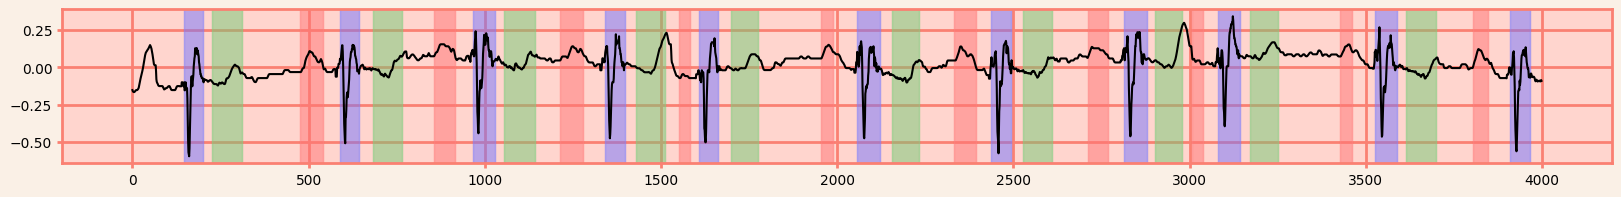

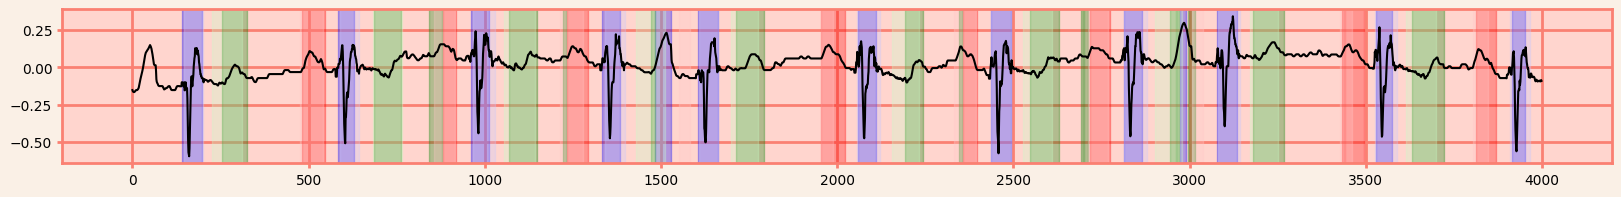

In [114]:
x = test_loader.dataset[0][0].unsqueeze(0)
s = test_loader.dataset[0][1]

with torch.no_grad():
    p = m(x)

p[p >= 0.7] = 1
p[p < 0.7] = 0
test_loader.dataset.ecg_seg_plot(0, s)
test_loader.dataset.ecg_seg_plot(0, p[0])

In [3]:
ch =  torch.load(R"G:\Мой диск\ECG\checkpoints1\best_checkpoint.pth", map_location=torch.device('cpu'))

OSError: [Errno 22] Invalid argument

In [ ]:
H = ch['history']
m = UNet()
m.load_state_dict(ch["model_state_dict"])
m.eval()


x = test_loader.dataset[0][0].unsqueeze(0)
s = test_loader.dataset[0][1]

with torch.no_grad():
    p = m(x)

p[p >= 0.7] = 1
p[p < 0.7] = 0
test_loader.dataset.ecg_seg_plot(0, s)
test_loader.dataset.ecg_seg_plot(0, p[0])

NameError: name 'ch' is not defined

In [ ]:
plt.figure(figsize=(10, 5))

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][2]['P'])
plt.plot(X, Y, color='red', linestyle='--', label='P')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][5]['P'])
plt.plot(X, Y, color='red', linestyle='-', label='P_val')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][2]['R'])
plt.plot(X, Y, color='blue', linestyle='--', label='R')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][5]['R'])
plt.plot(X, Y, color='blue', linestyle='-', label='R_val')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][2]['T'])
plt.plot(X, Y, color='green', linestyle='--', label='T')

X = []
Y = []
for i in range(29):
    X.append(i)
    Y.append(ch['history'][i][5]['T'])
plt.plot(X, Y, color='green', linestyle='-', label='T_val')

plt.grid()
plt.legend()

NameError: name 'ch' is not defined

<Figure size 1000x500 with 0 Axes>

(5000,)


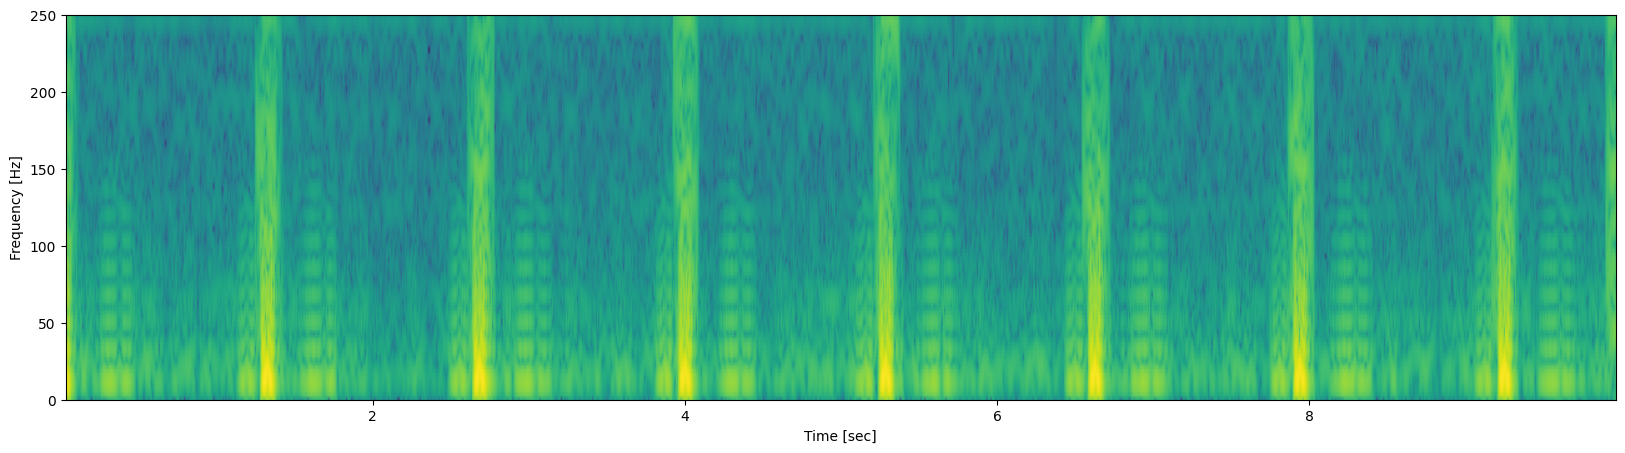

(100, 1242)

In [ ]:
# s = test_loader.dataset[0][0]

# plt.figure(figsize=(20, 5))
# a = plt.specgram(s[0], Fs=FREQUENCY, scale='dB')[0]

# test_loader.dataset.ecg_seg_plot(0)
# plt.xlim(0, 4000)

SPECTROGRAM     = {'fs': FREQUENCY,
              'nperseg': 33,
             'noverlap': 29,
                 'nfft': 198}
plt.figure(figsize=(20, 5))
s = wfdb.rdrecord(DATA_PATH+R"\1").p_signal.T[1]
print(s.shape)
f, t, Sxx = signal.spectrogram(s, **SPECTROGRAM)
Sxx = 10 * np.log10(Sxx)
plt.pcolormesh(t, f, Sxx, shading='gouraud')

# plt.ylim(0, 50)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Sxx.shape

C:\Users\George.LAPTOP-TLP259VH\AppData\Local\Temp\ipykernel_13088\1996791126.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=size)


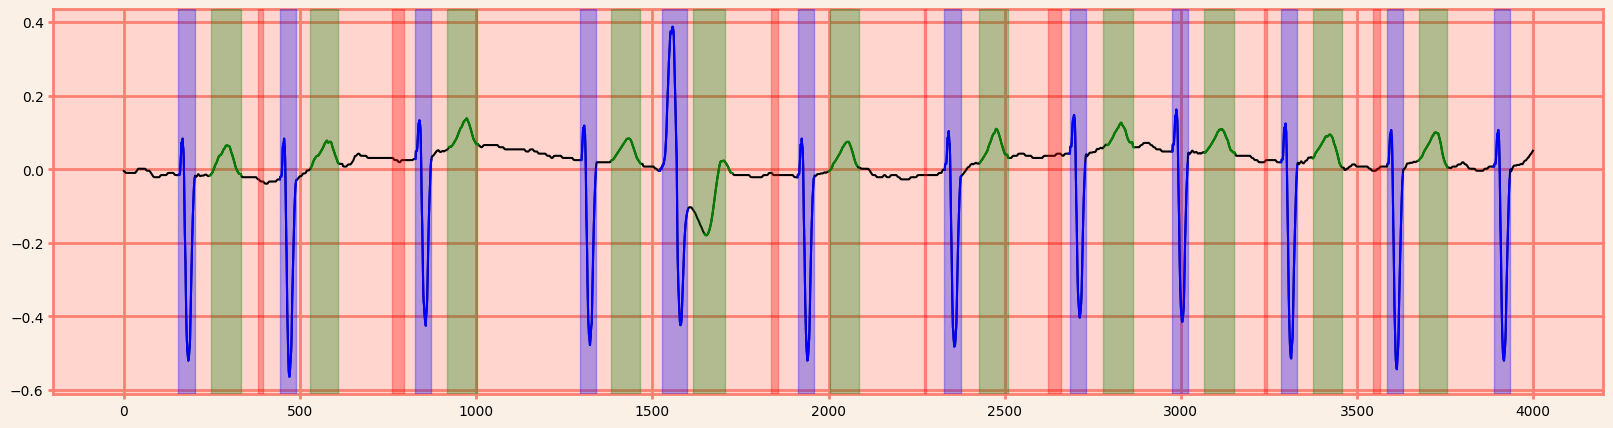

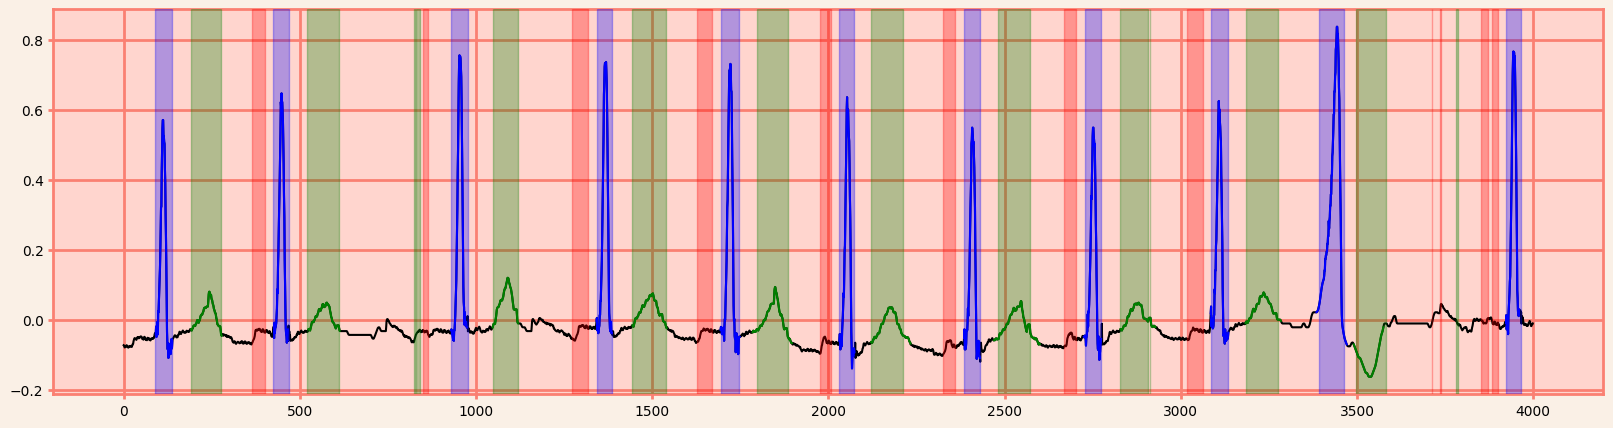

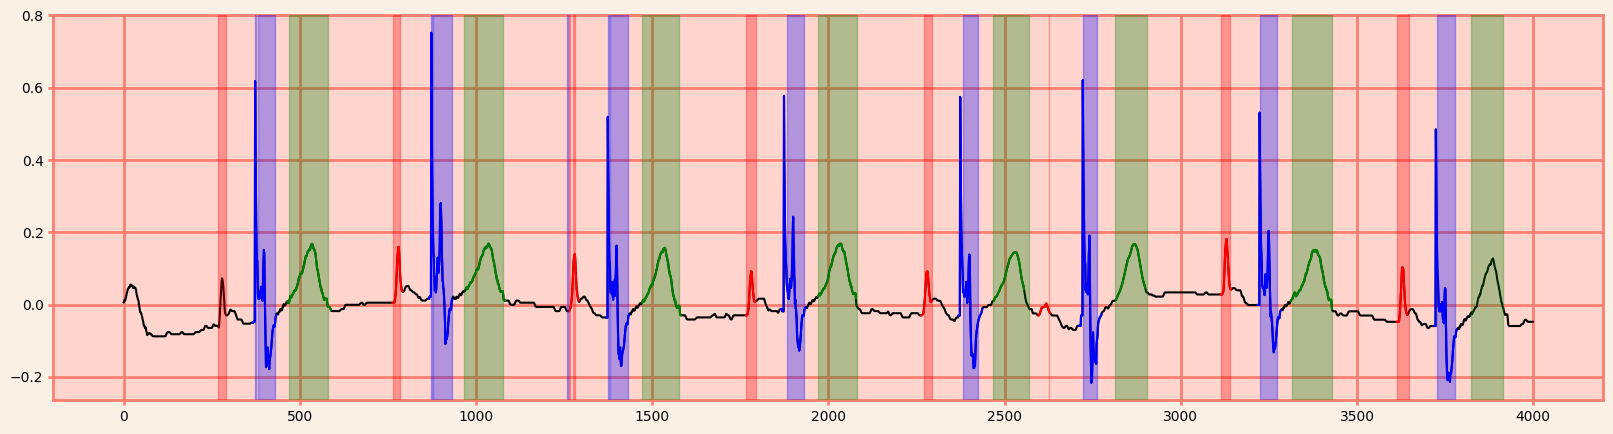

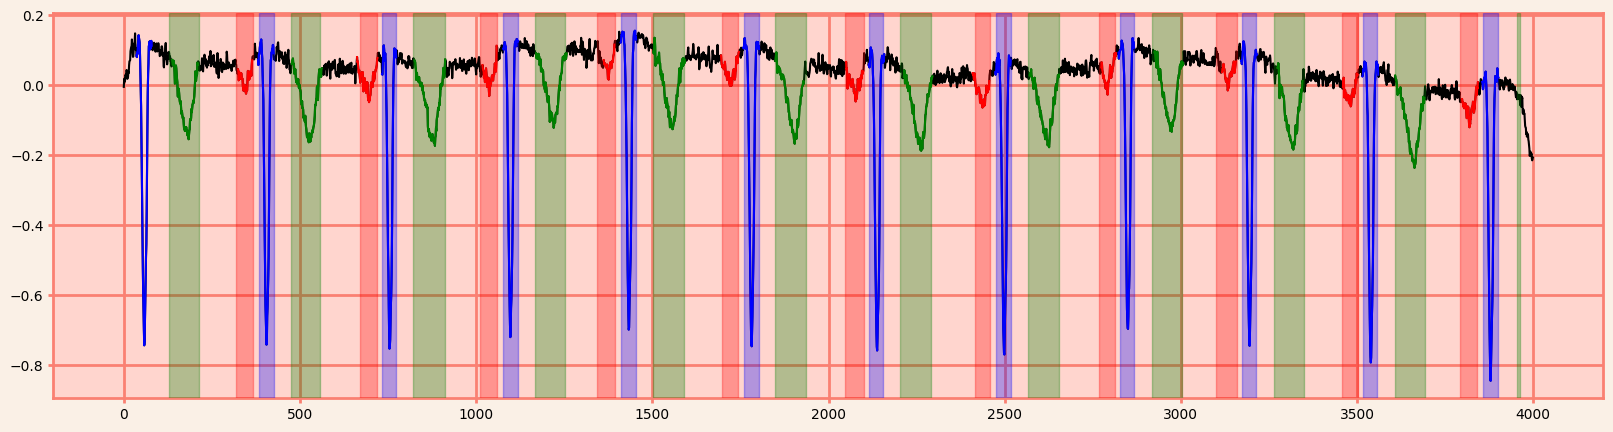

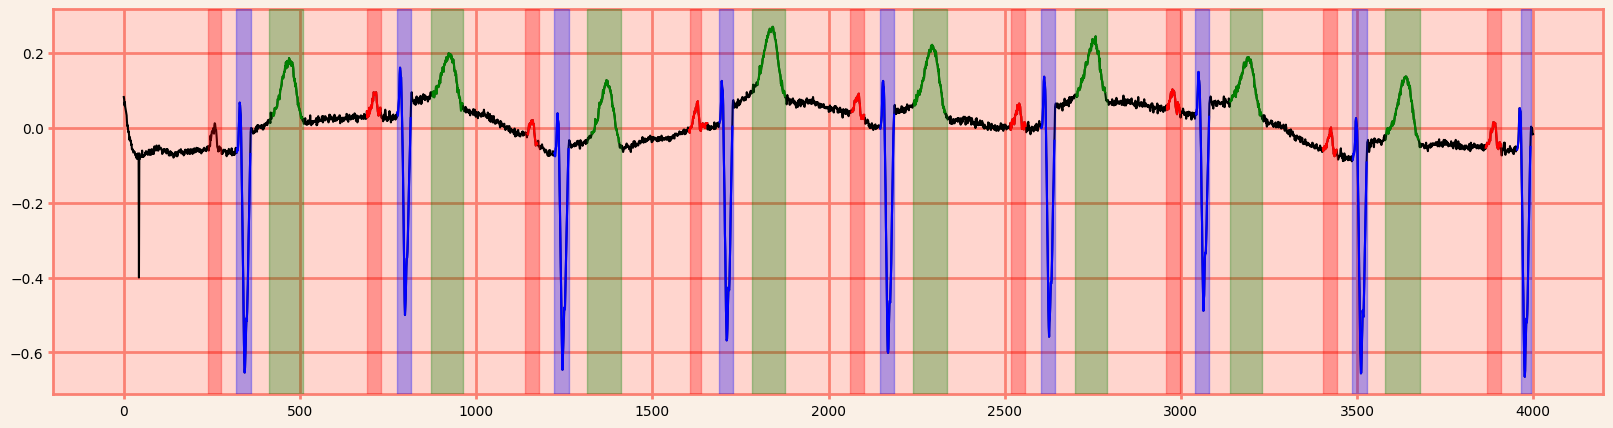

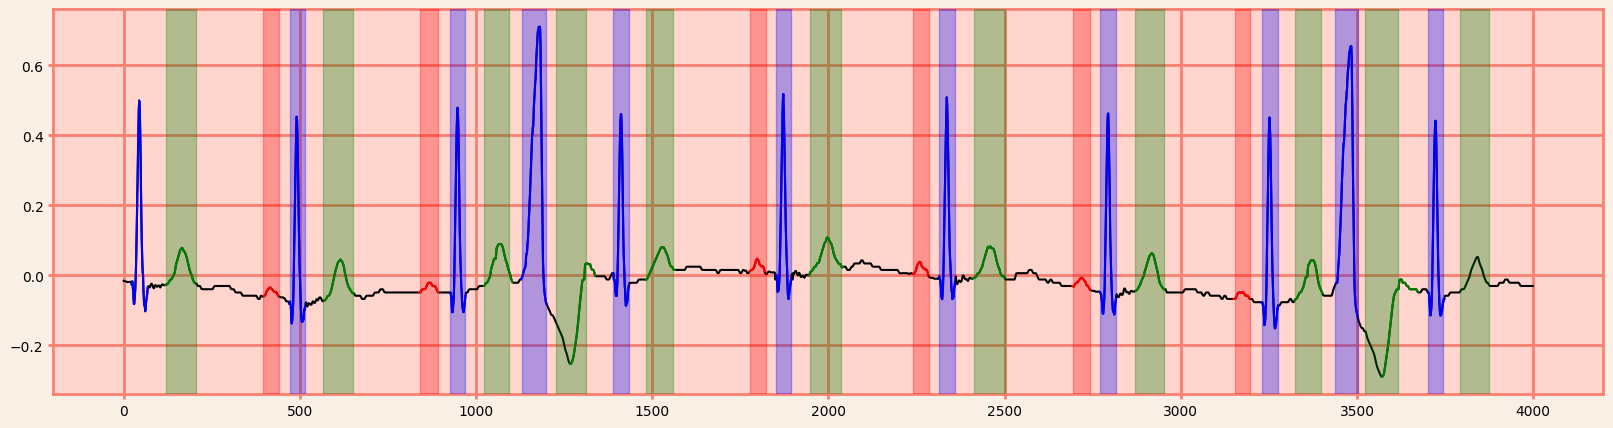

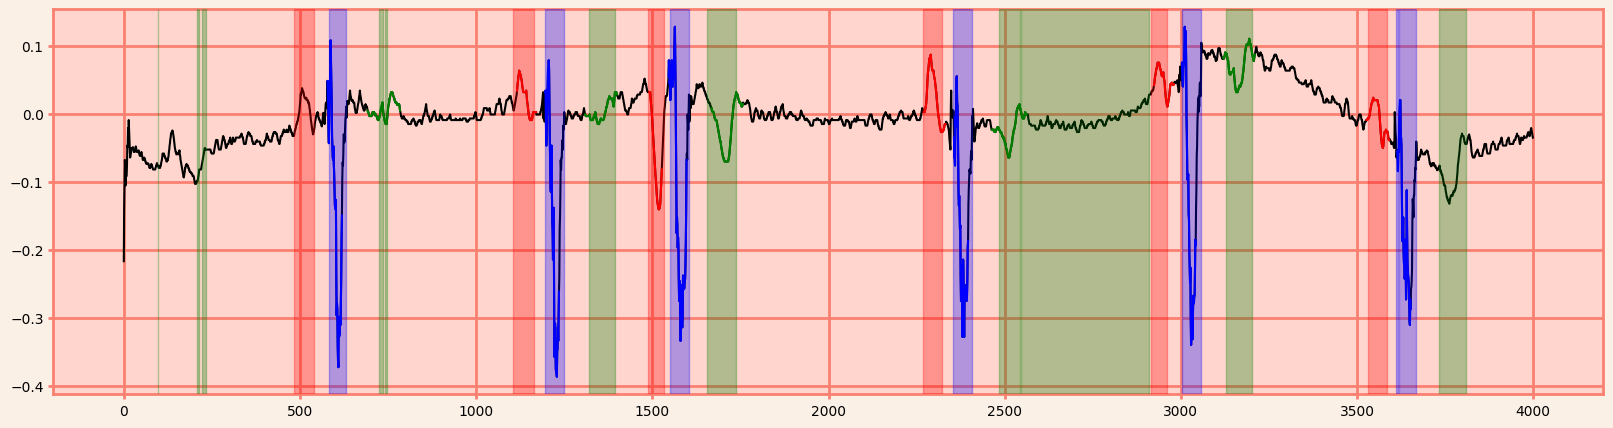

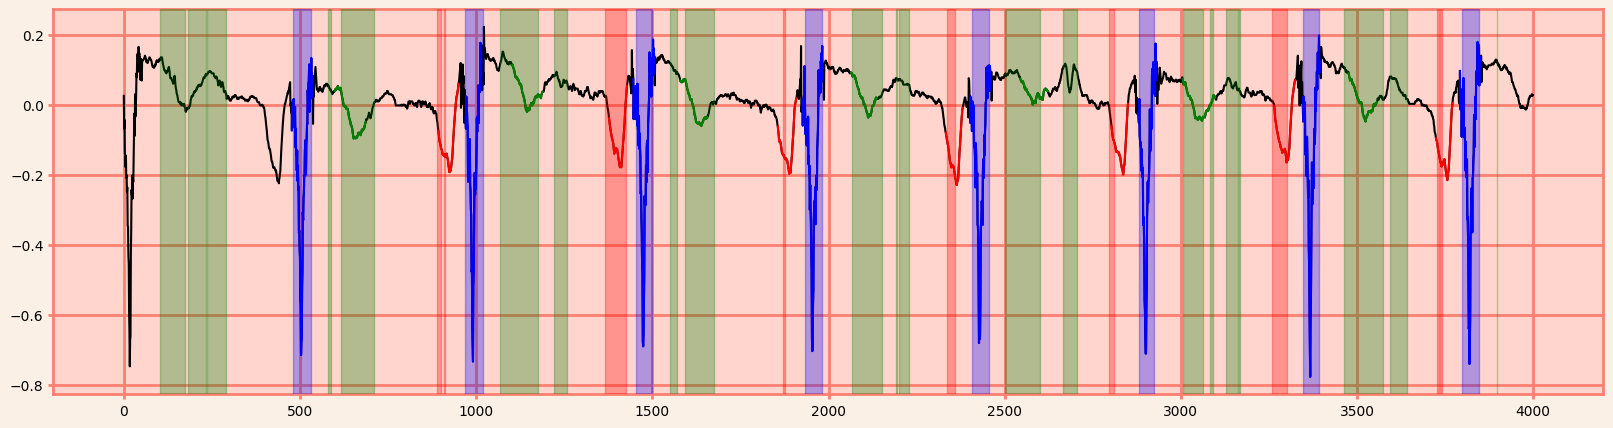

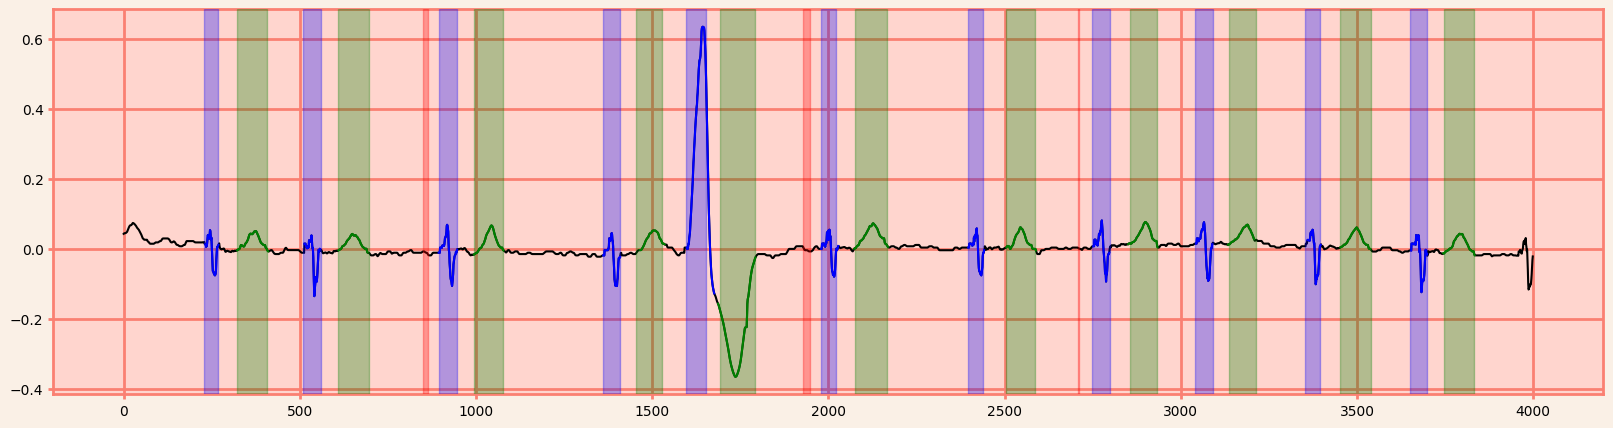

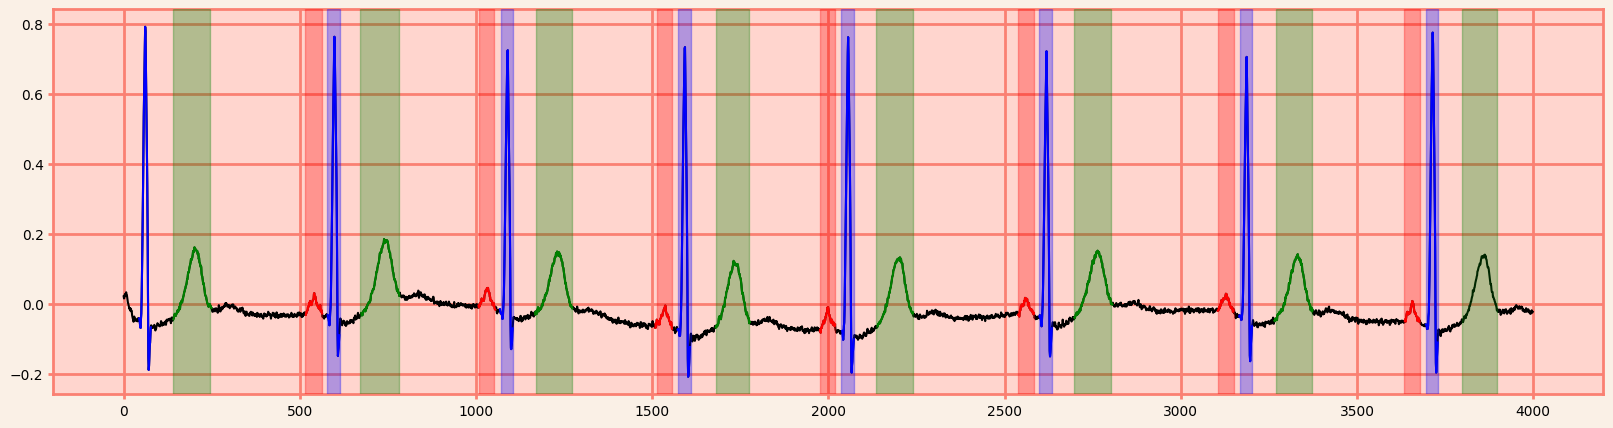

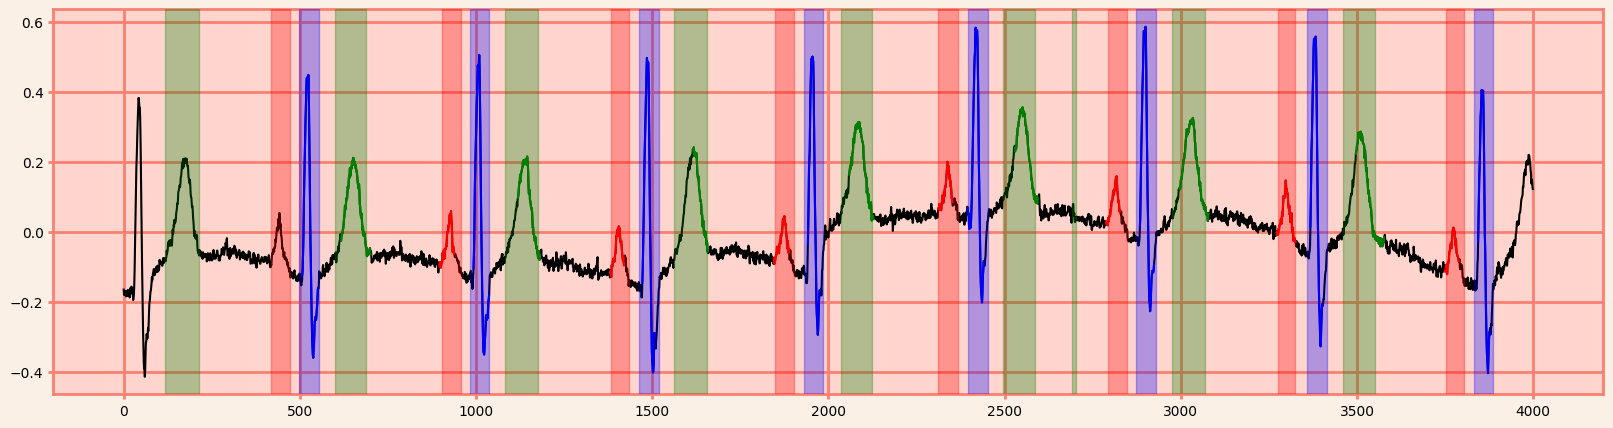

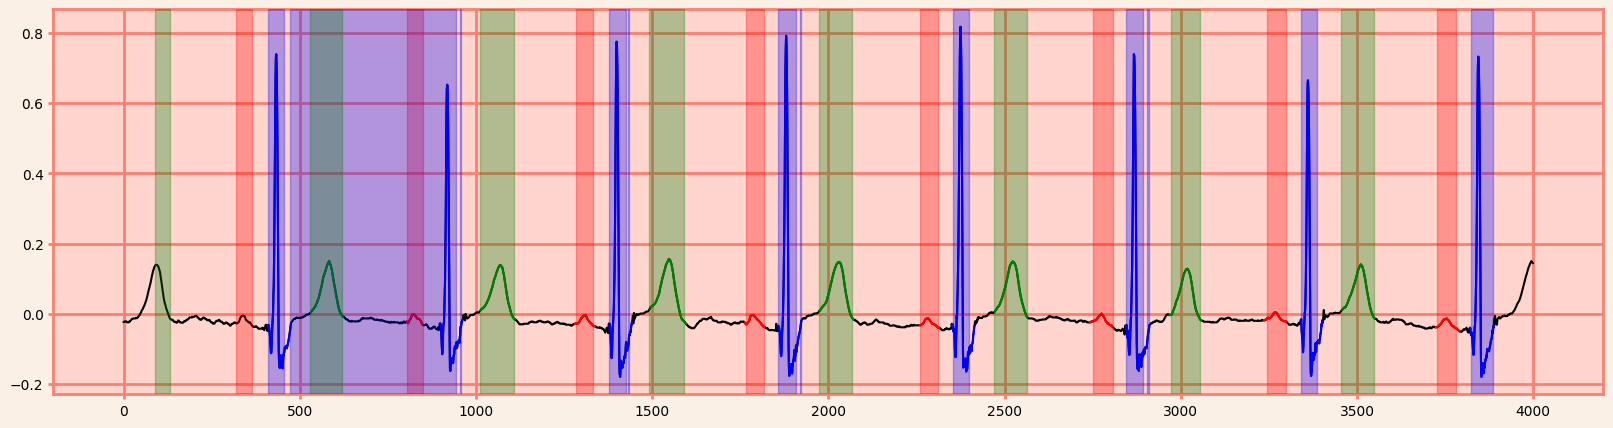

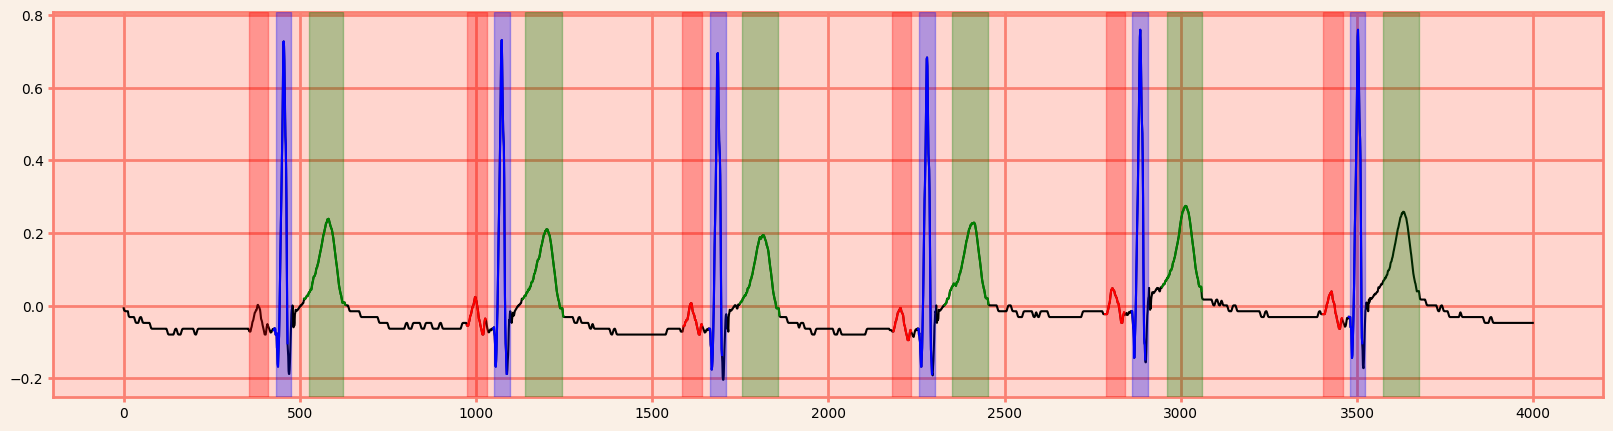

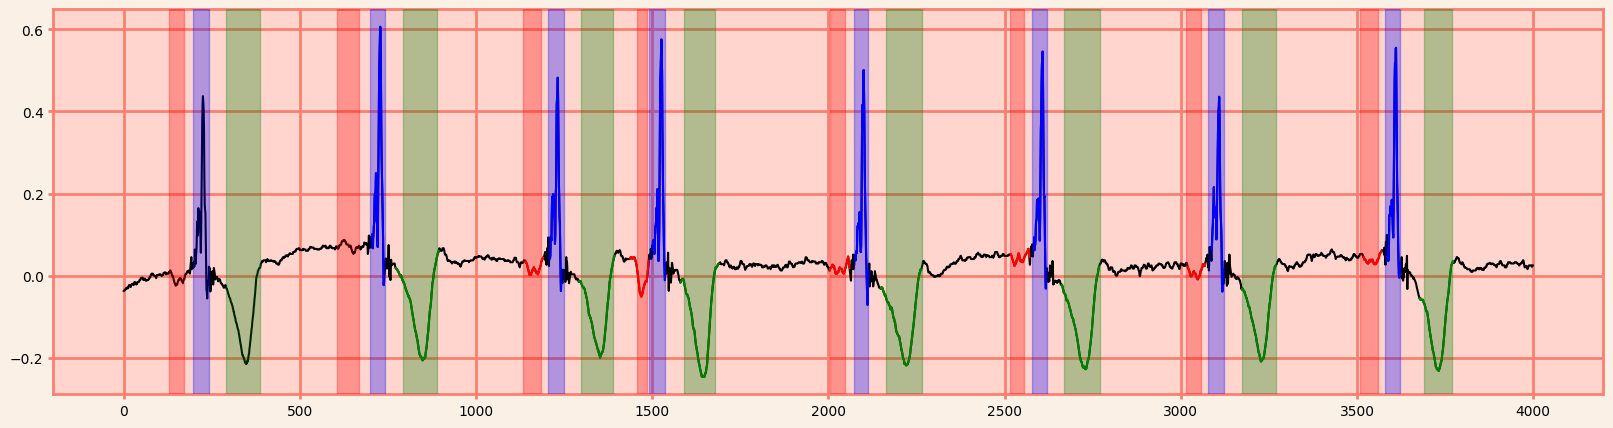

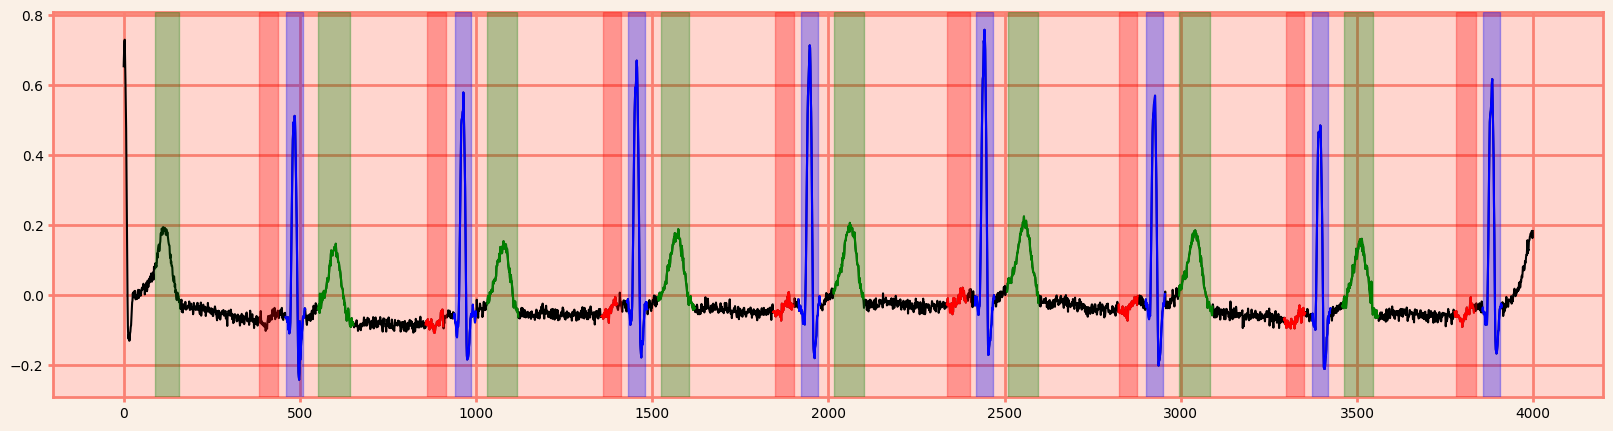

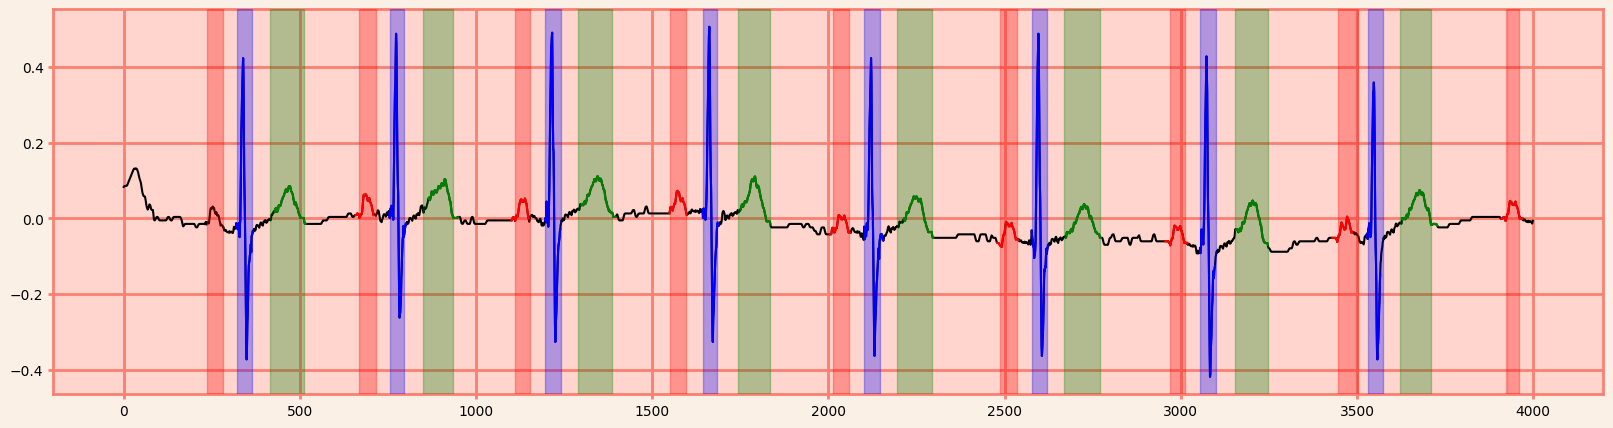

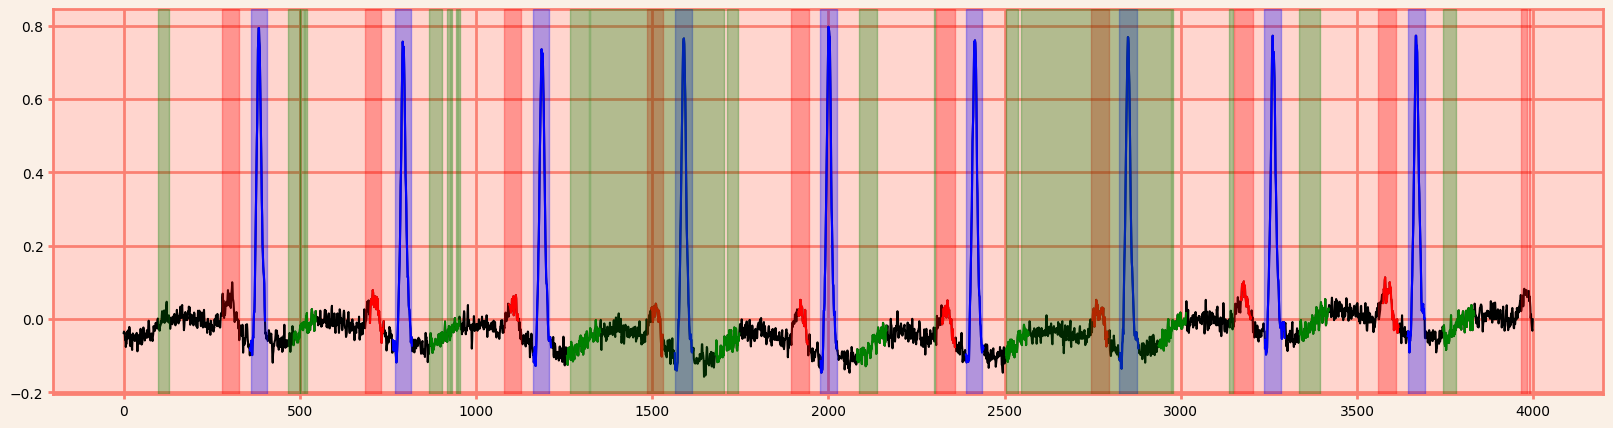

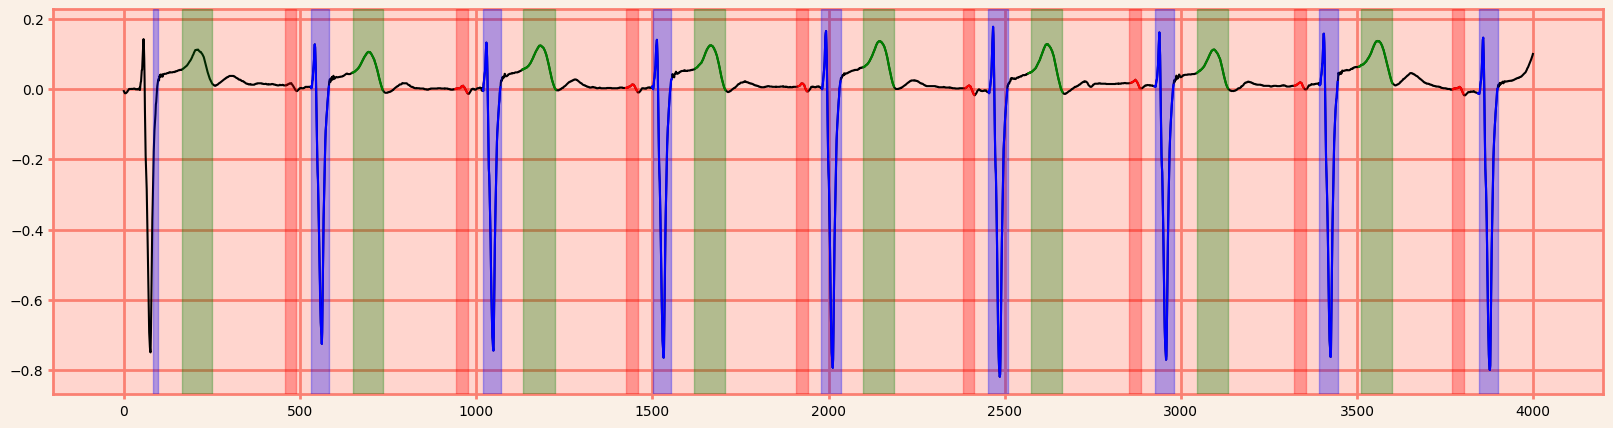

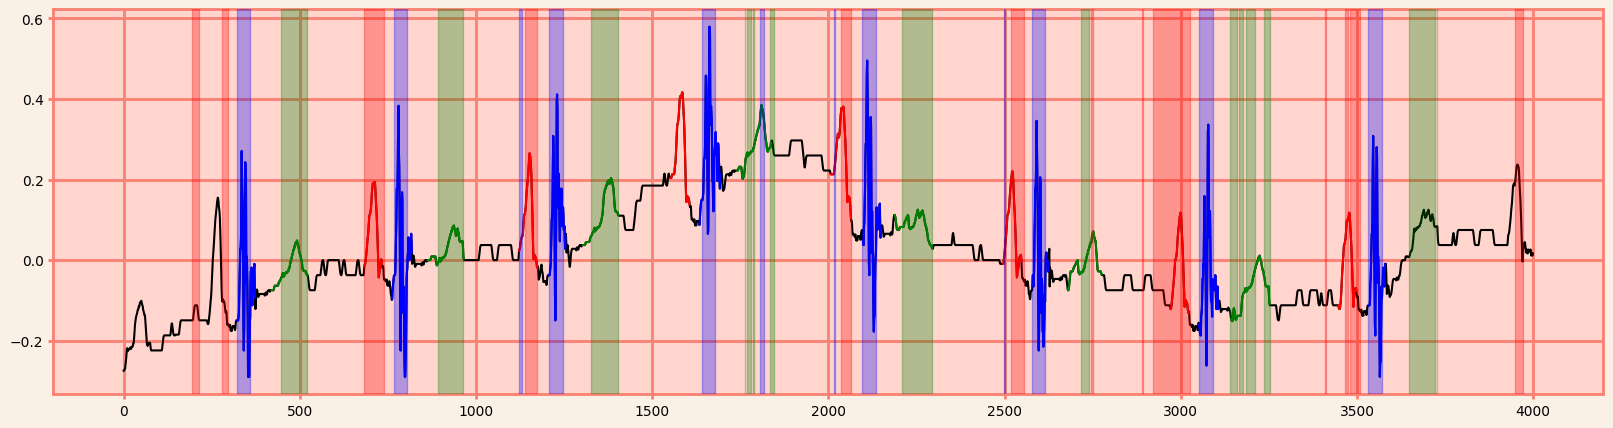

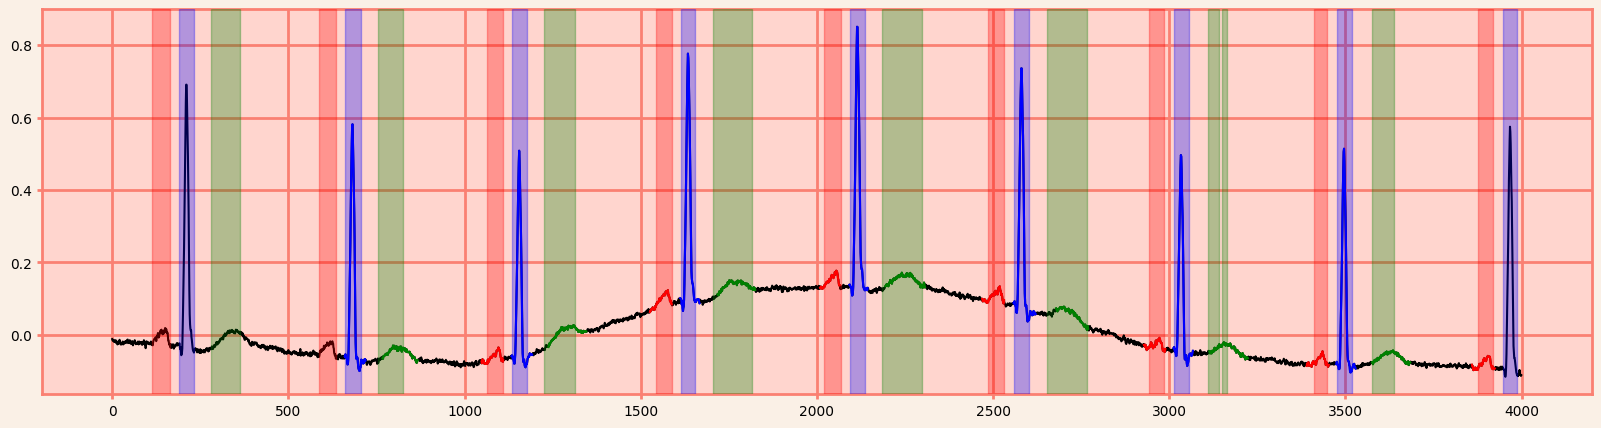

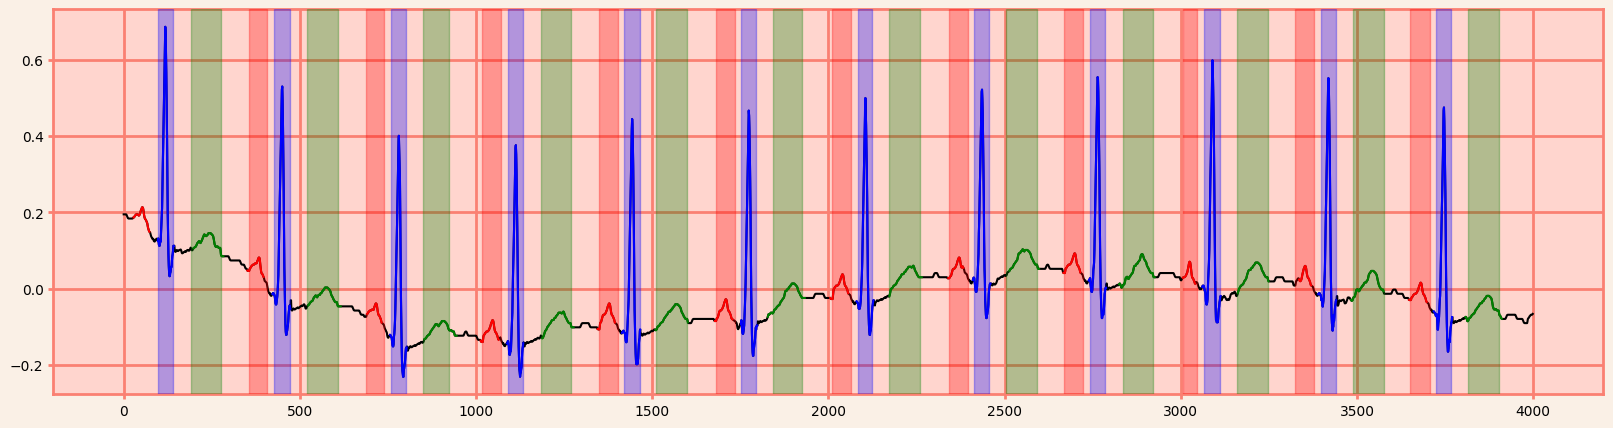

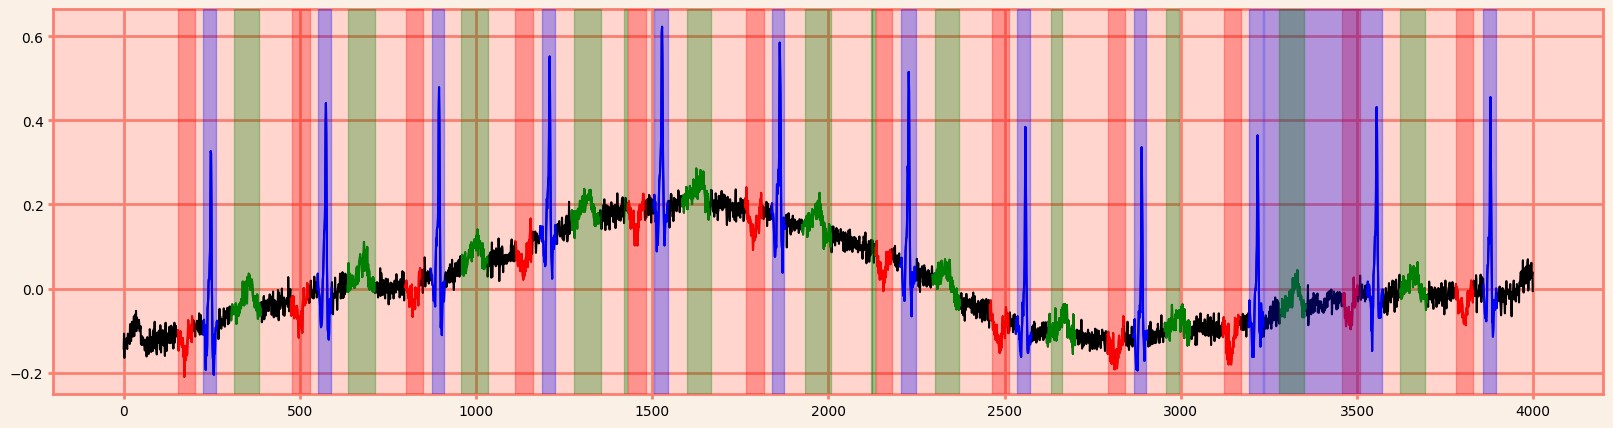

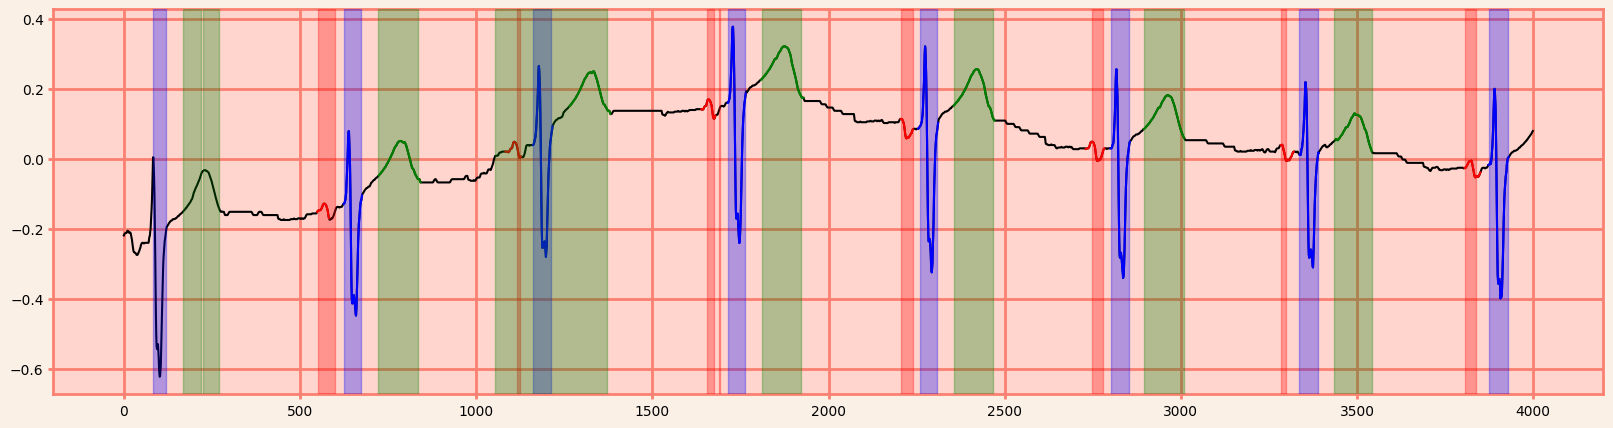

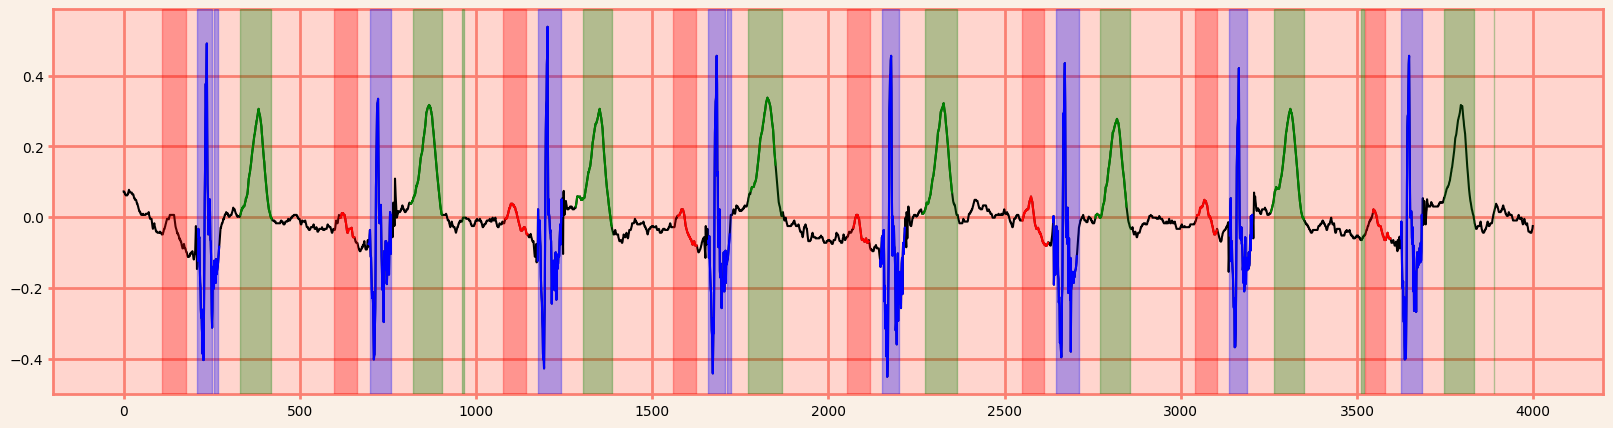

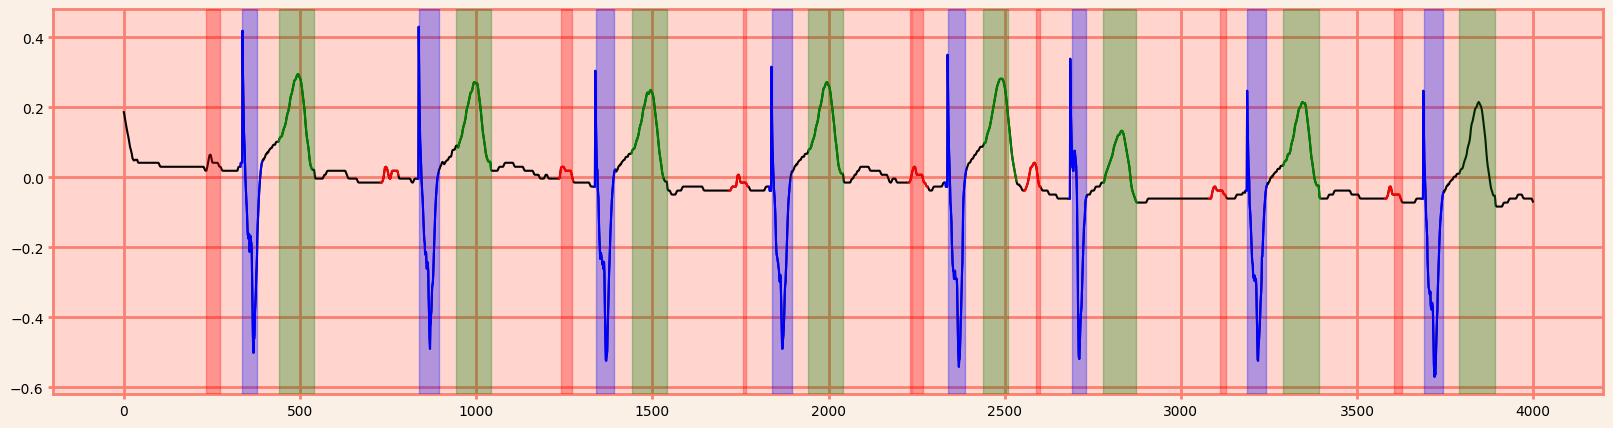

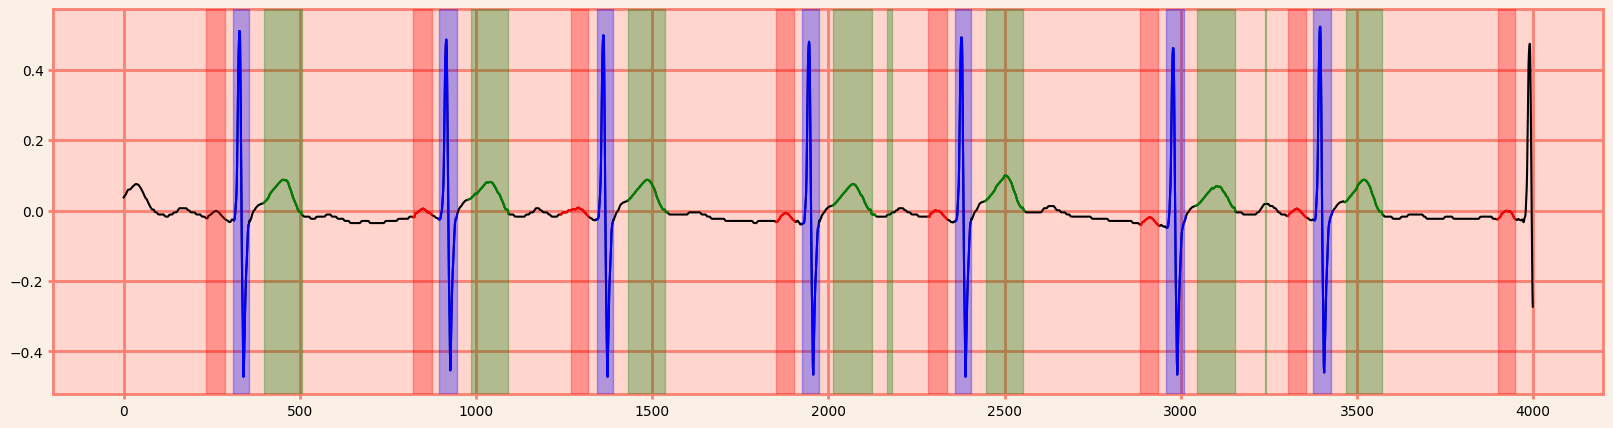

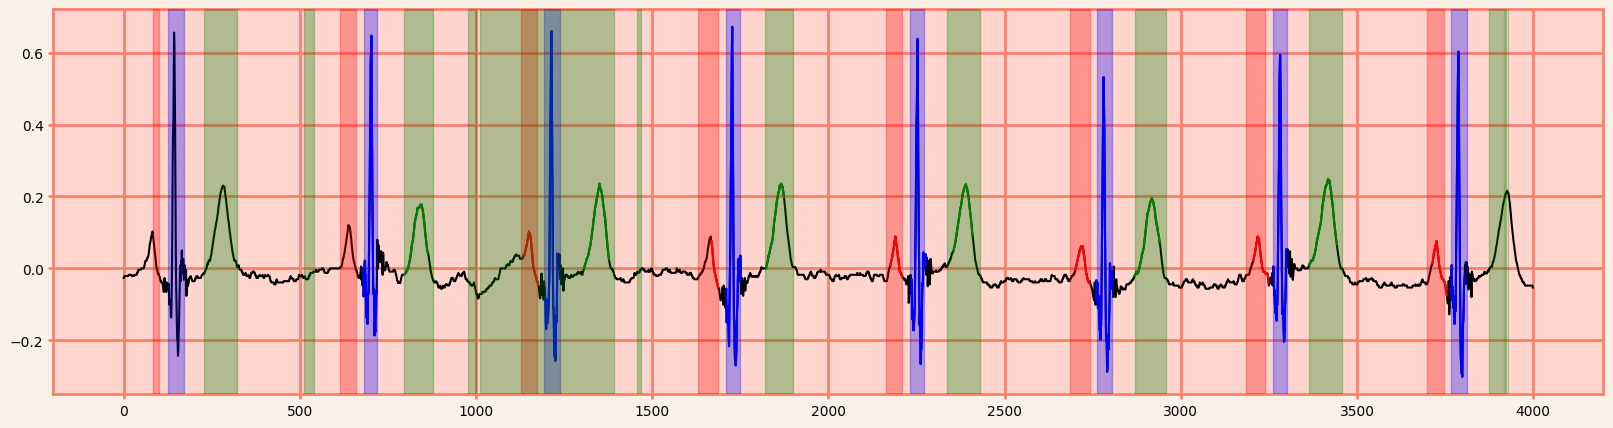

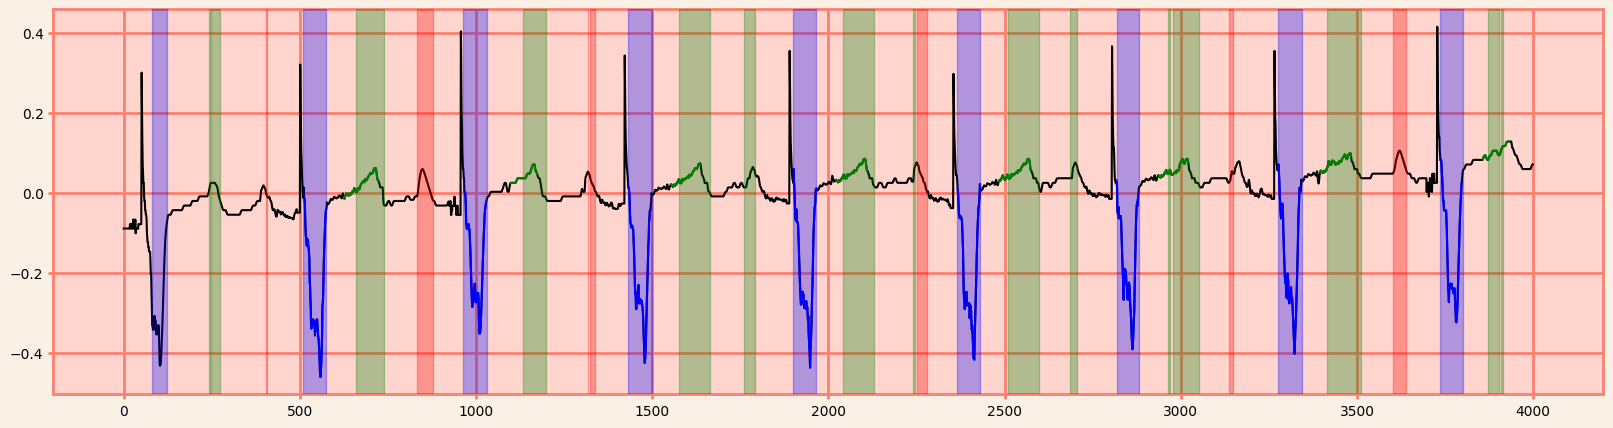

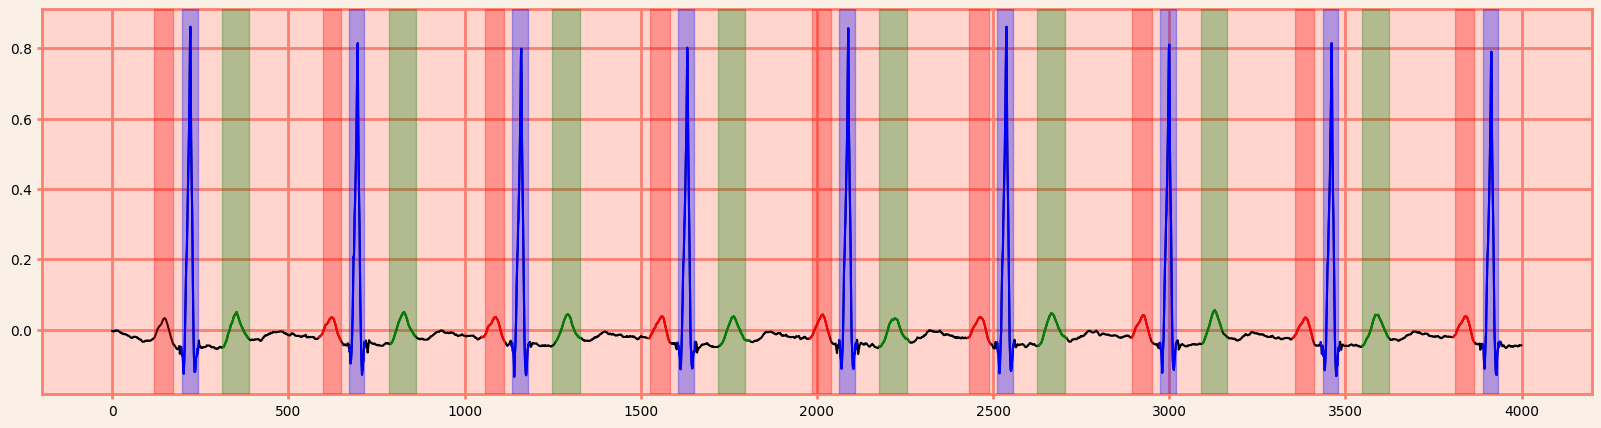

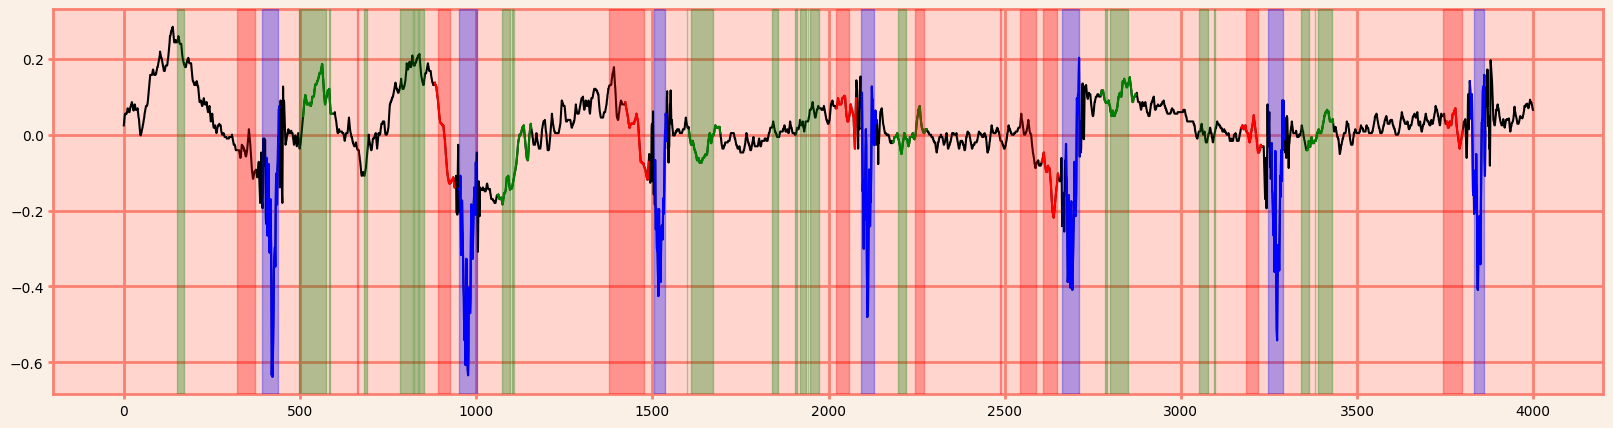

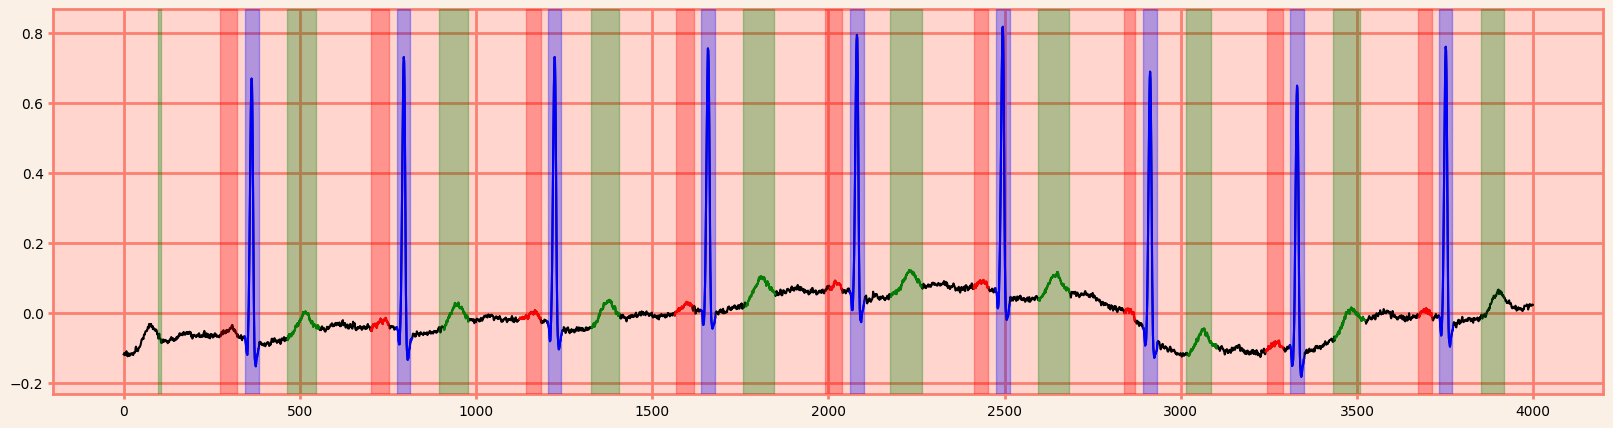

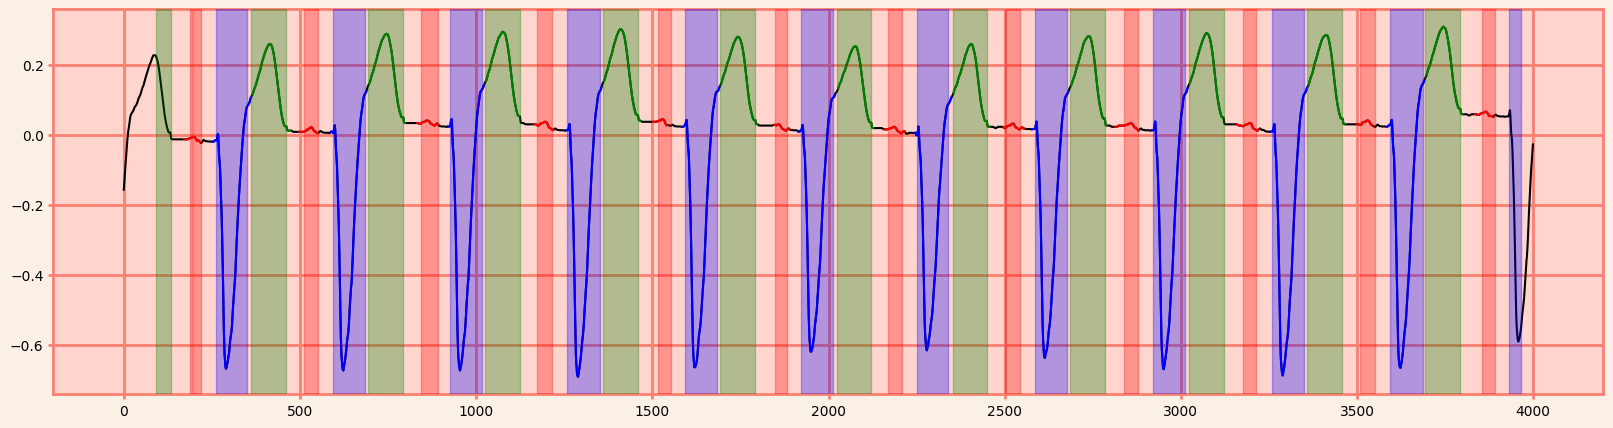

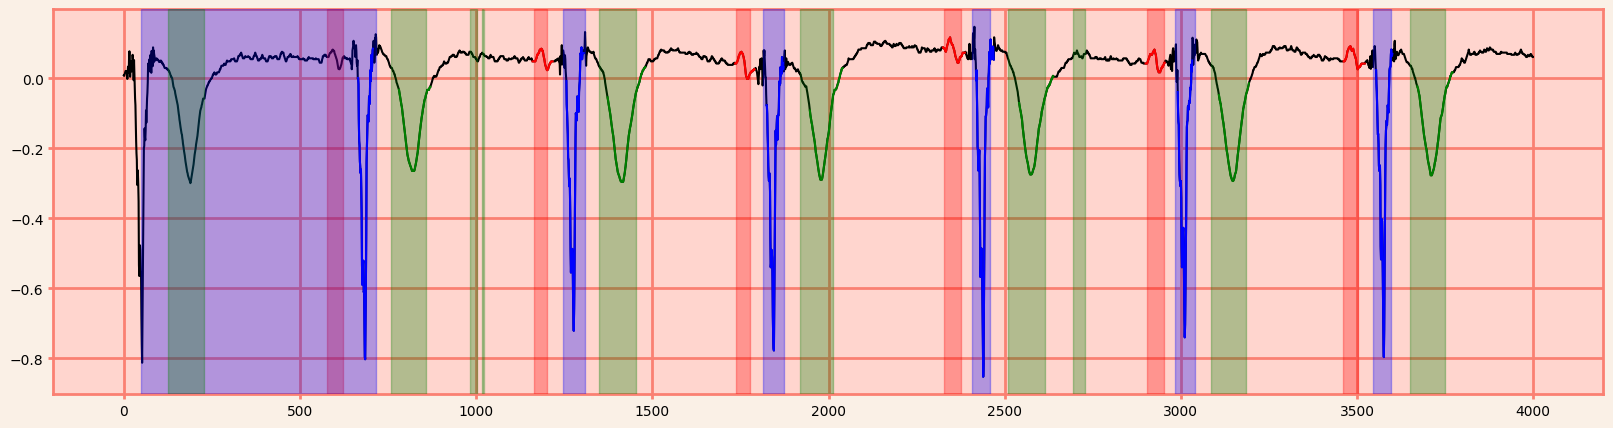

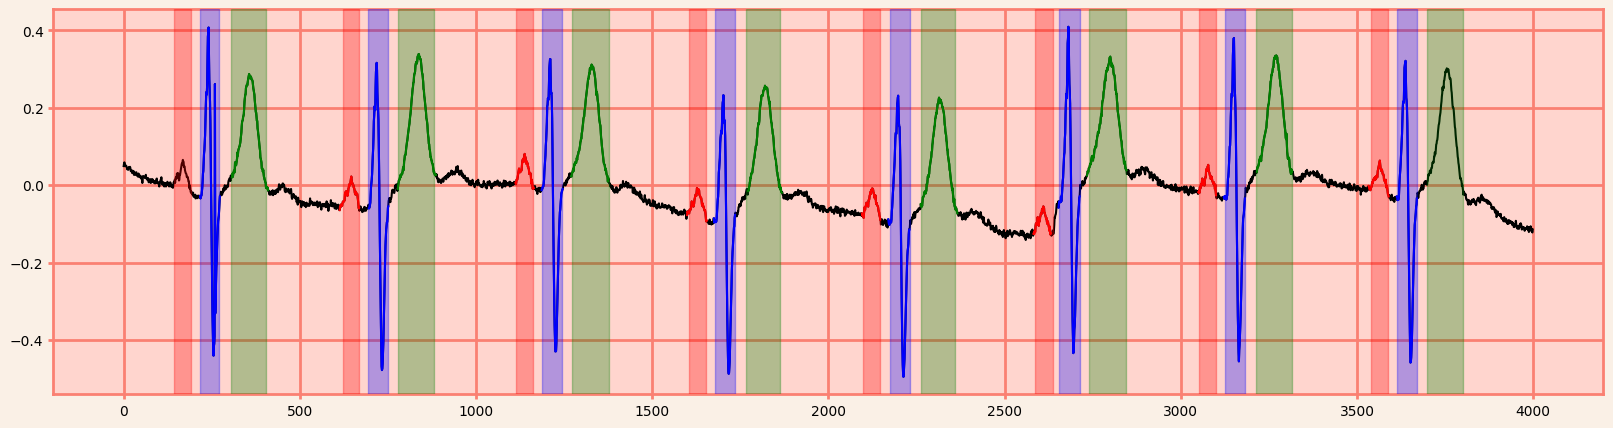

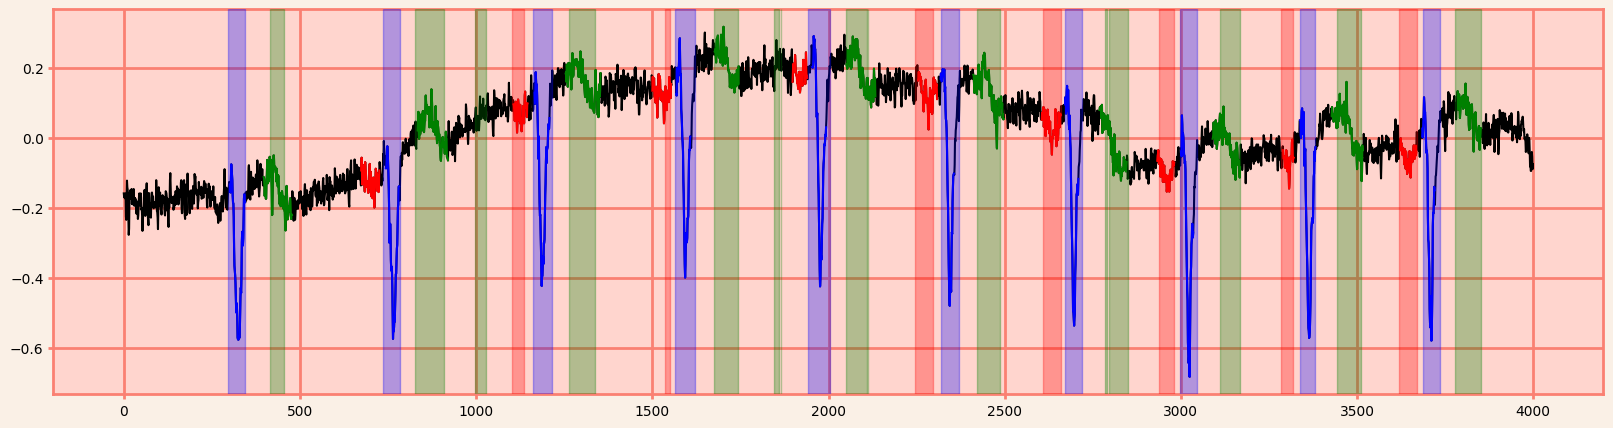

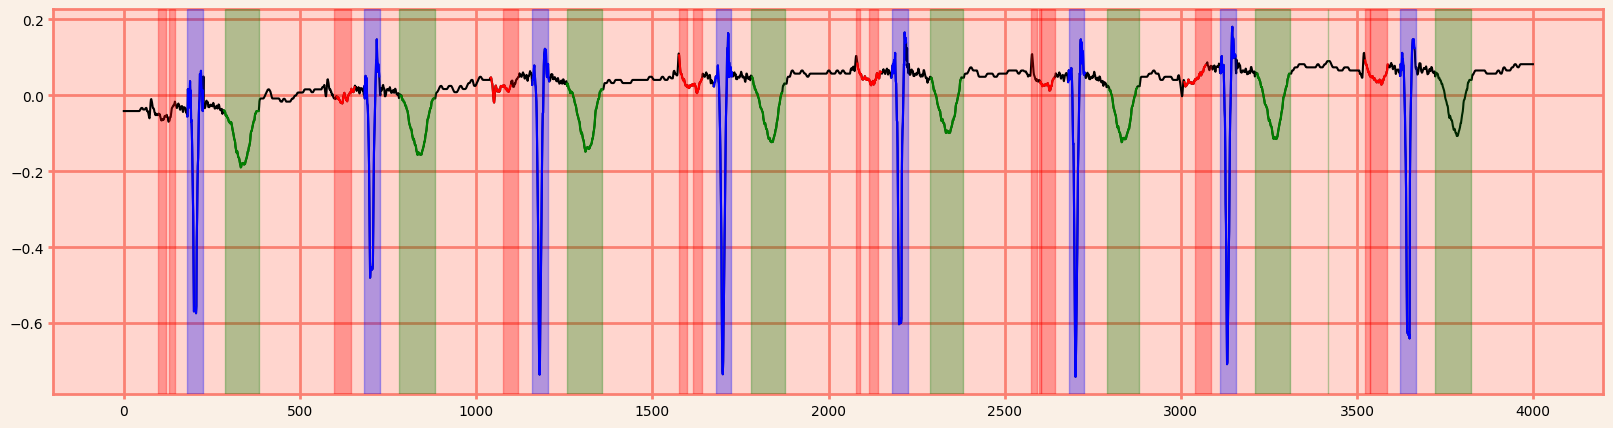

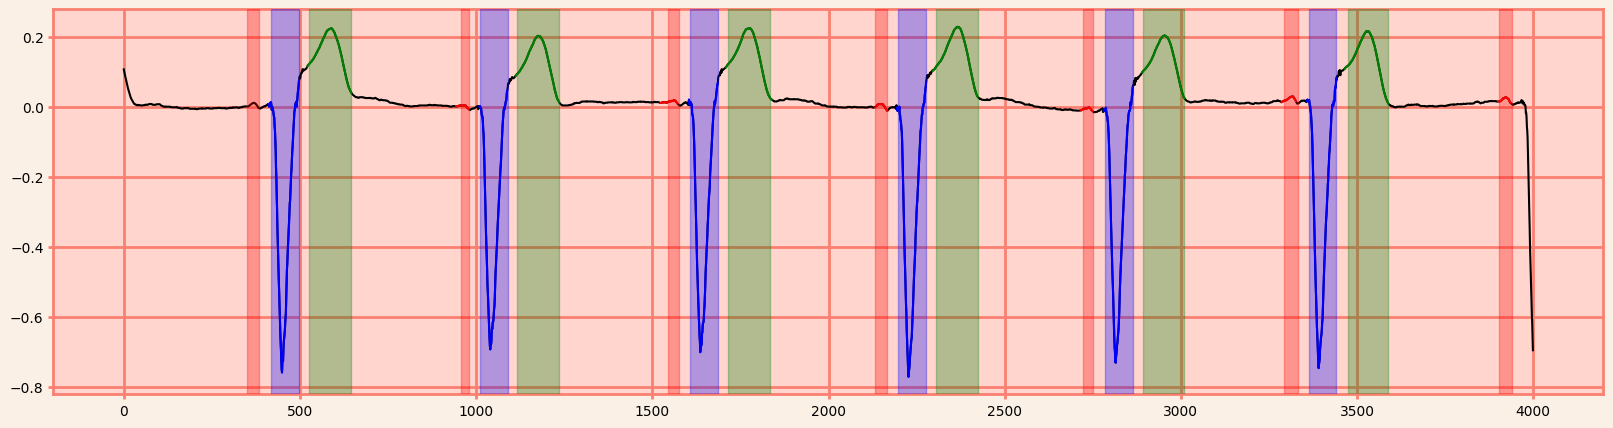

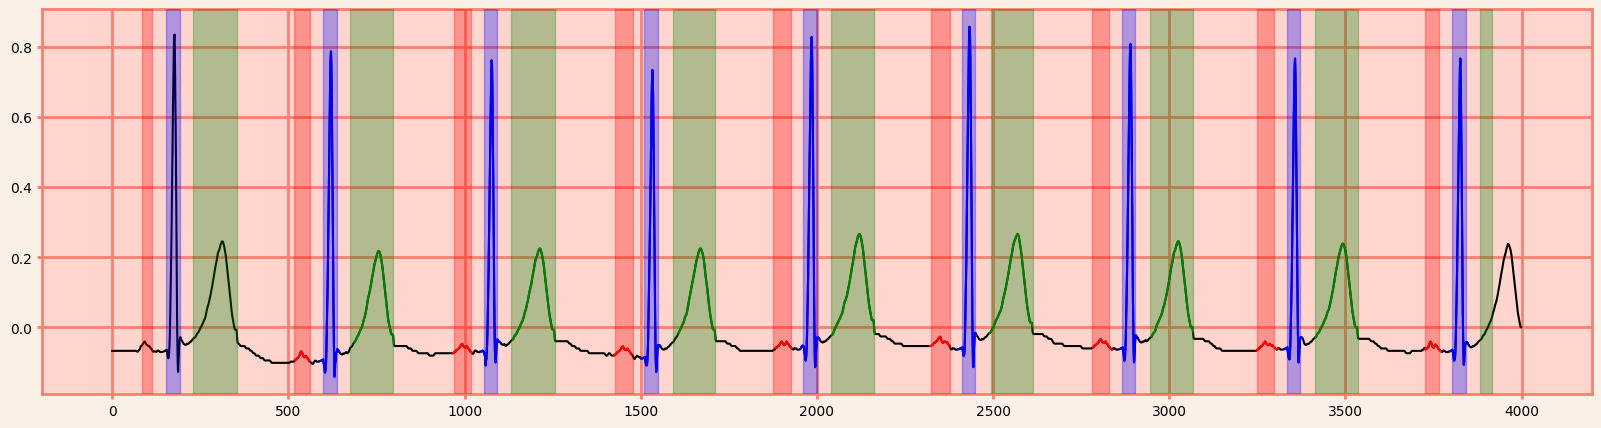

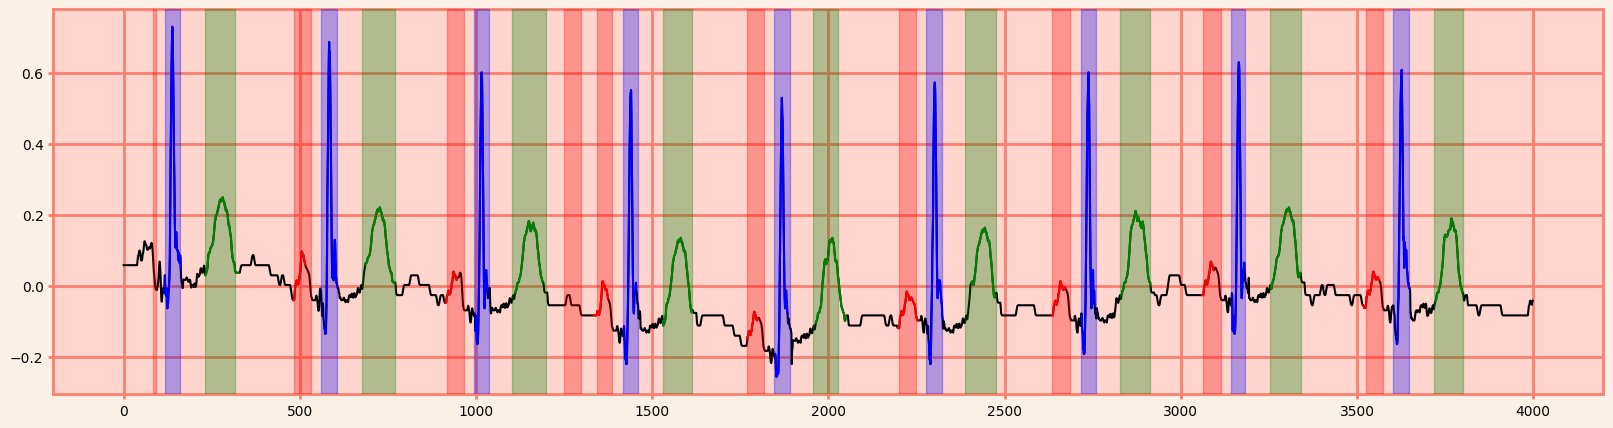

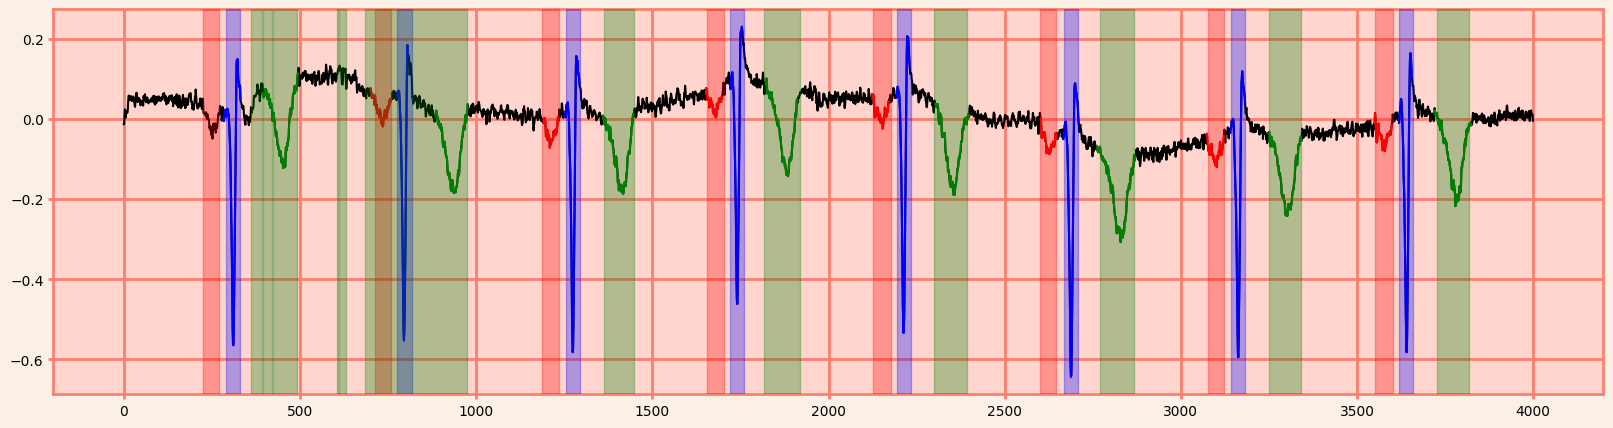

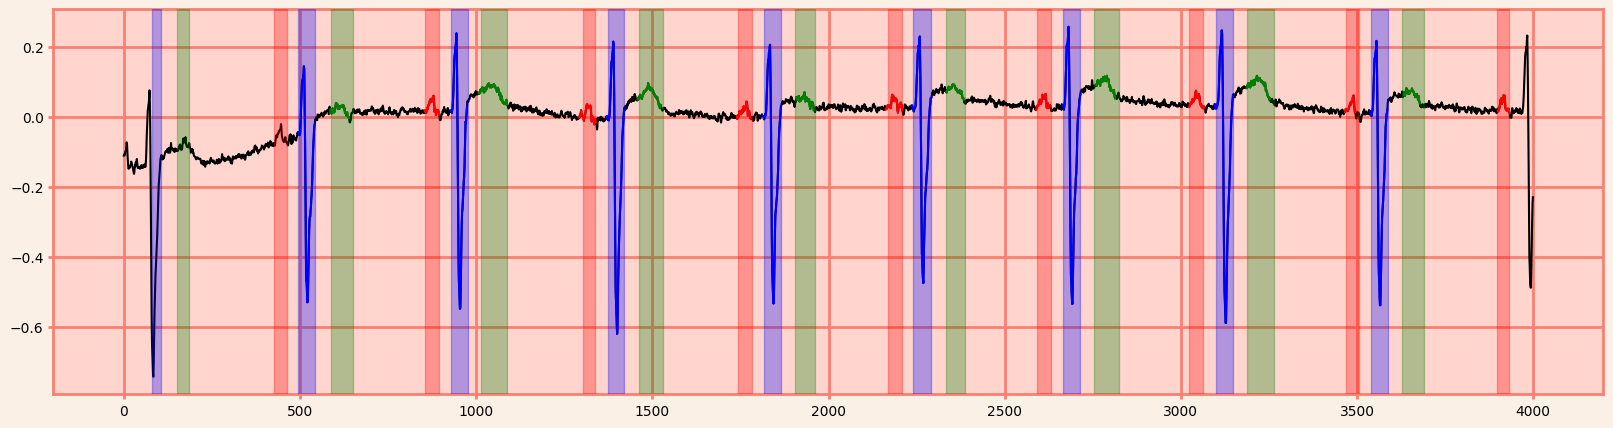

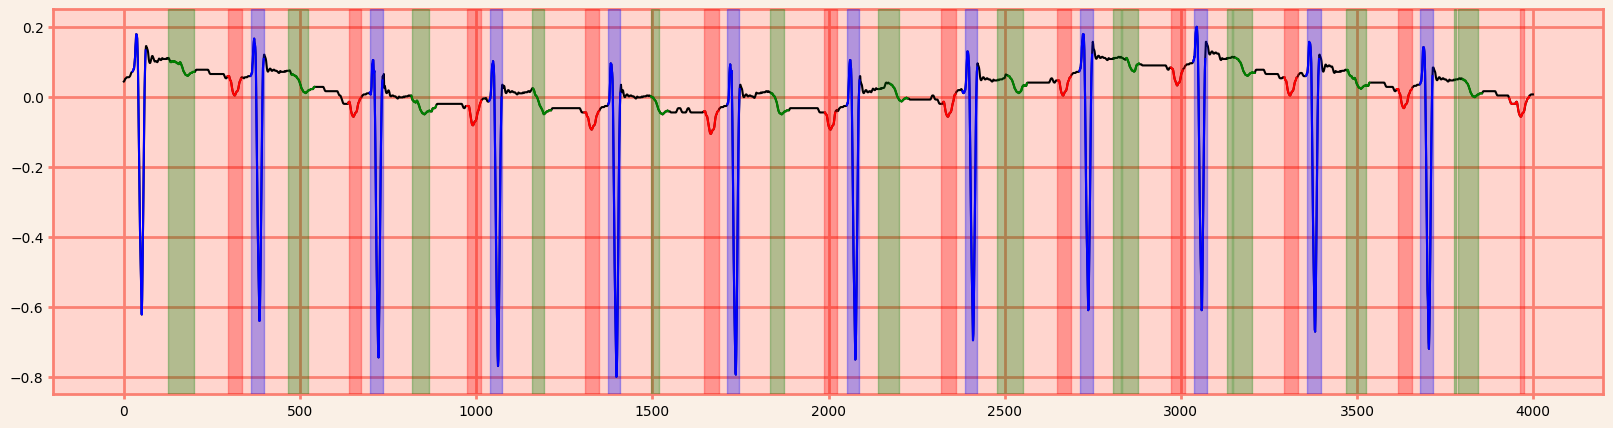

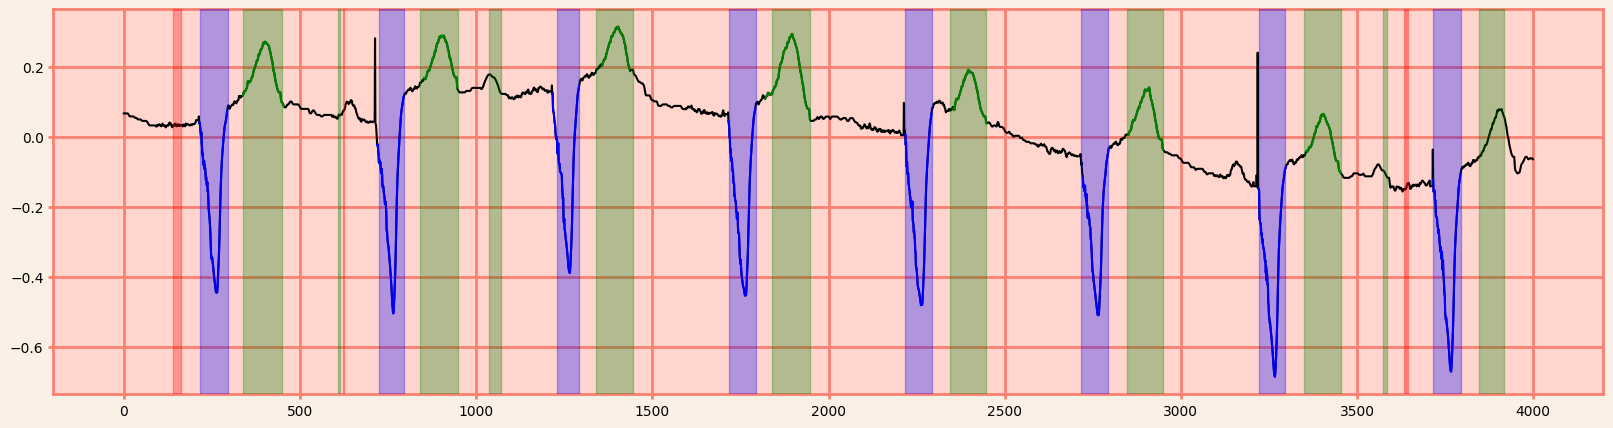

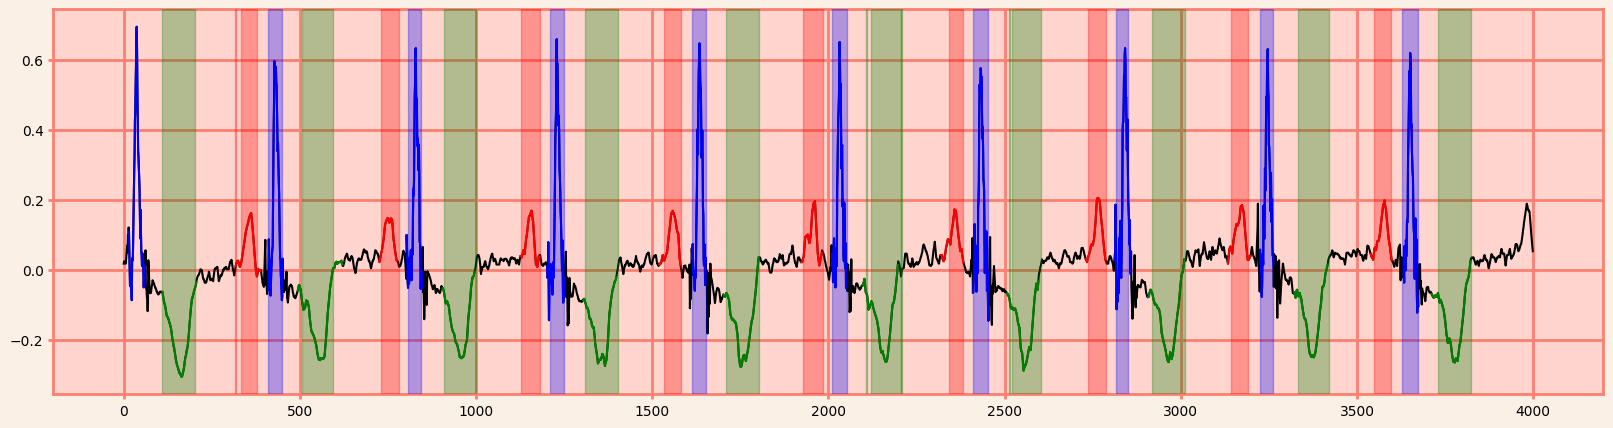

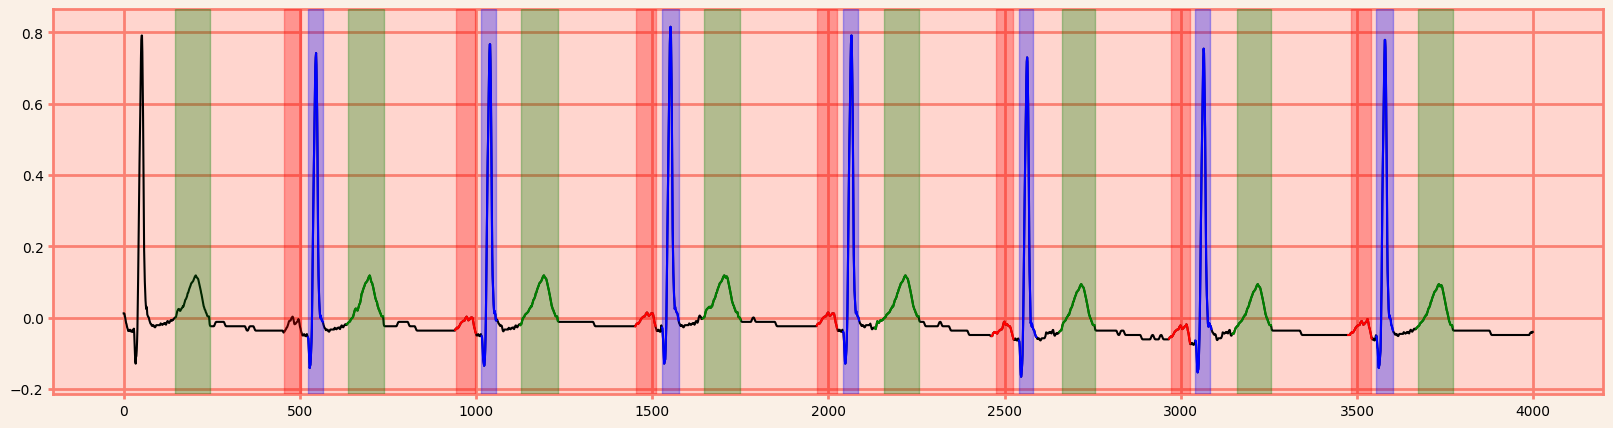

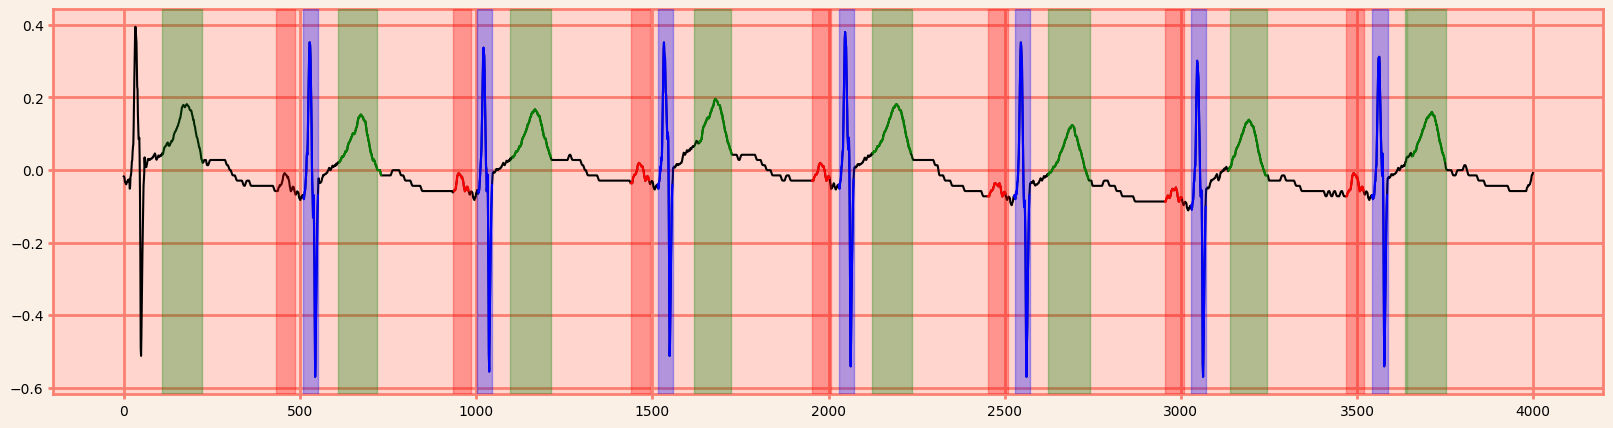

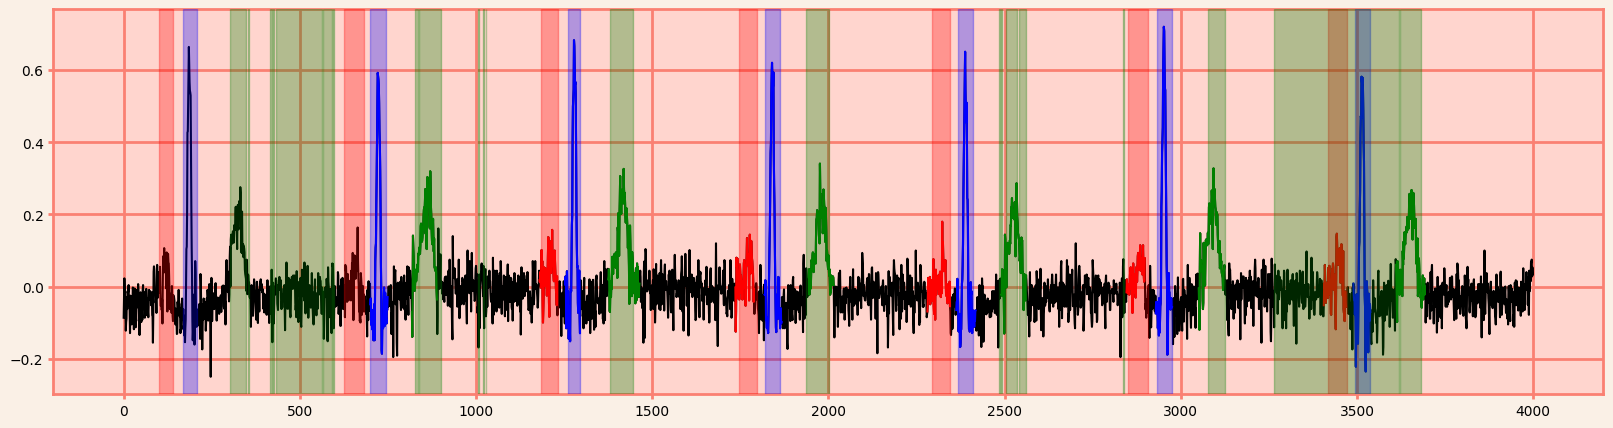

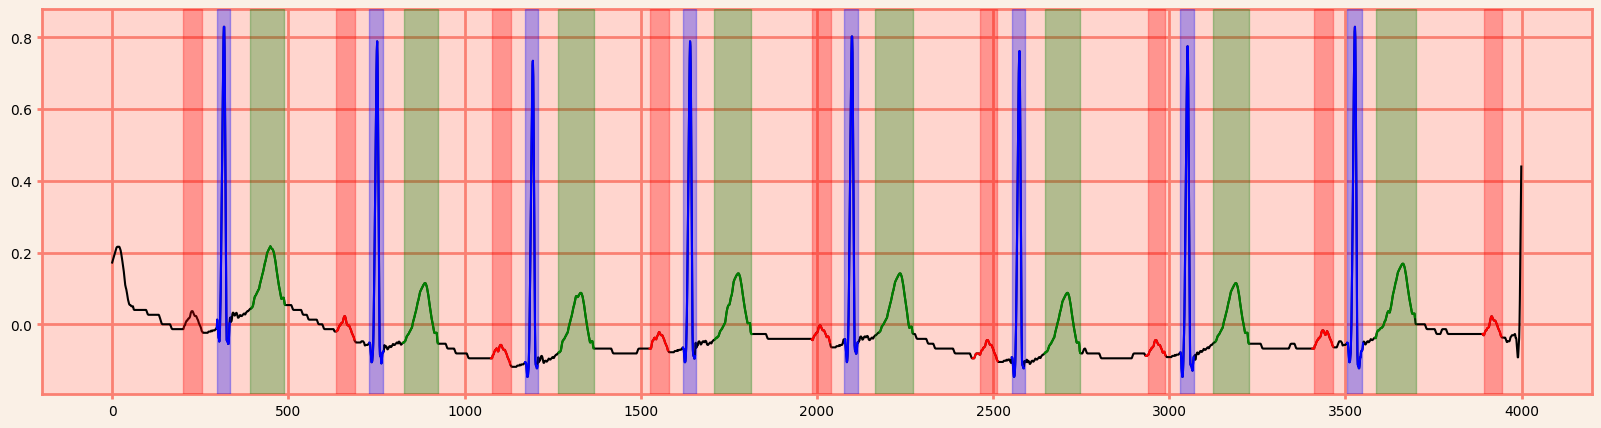

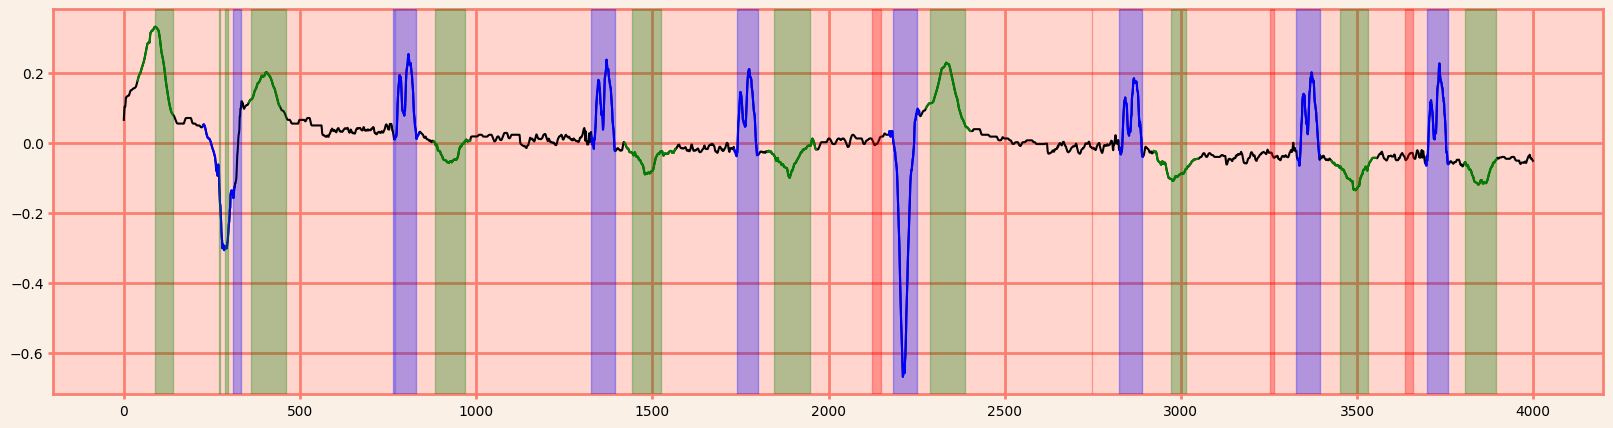

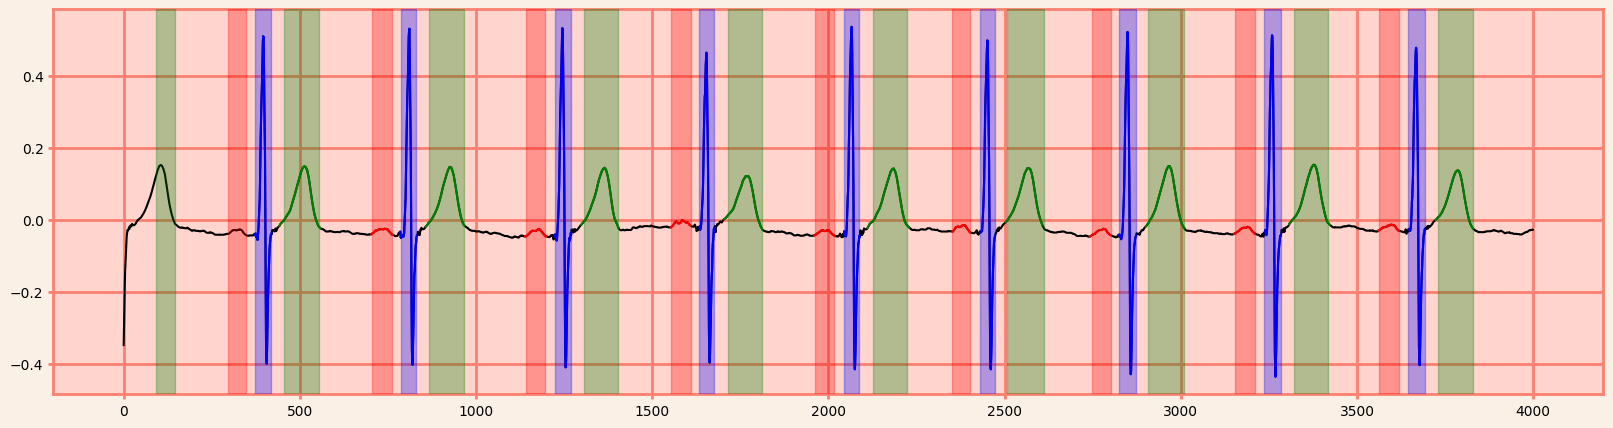

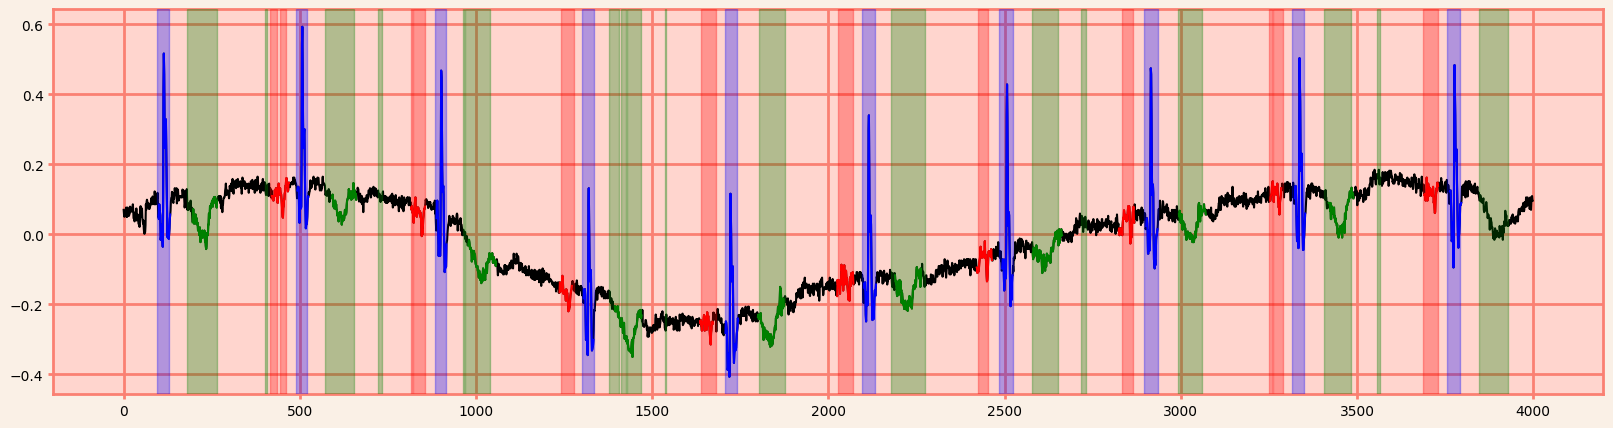

In [226]:
ch =  torch.load(R"D:\256\best_checkpoint.pth", map_location=torch.device('cpu'))
m = UNet_1d(ENC_DIMS, 4, CONV)
m.load_state_dict(ch["model_state_dict"])
m.eval()


for i in range(0, 51):
    x = val_loader.dataset[i][0].unsqueeze(0)
    s = val_loader.dataset[i][1]

    with torch.no_grad():
        p = m(x)

    p[p >= 0.9] = 1
    p[p < 0.9] = 0
    val_loader.dataset.ecg_seg_plot(i, seg1=s, seg2=p[0], size=(20, 5))

In [ ]:
for u in range(1, 100):
    for w in range(u+1, 100):
        if int((4000 - u)/(w - u)) % 32 == 0 and (4000 - u)/(w - u) < 1000:
            print(w, u)

63 1
33 2
64 2
34 3
65 3
35 4
66 4
36 5
67 5
37 6
68 6
38 7
69 7
39 8
70 8
40 9
71 9
41 10
72 10
42 11
73 11
43 12
74 12
44 13
75 13
45 14
76 14
46 15
77 15
47 16
78 16
48 17
79 17
49 18
80 18
50 19
81 19
51 20
82 20
52 21
83 21
53 22
84 22
54 23
85 23
55 24
65 24
86 24
56 25
66 25
87 25
57 26
67 26
88 26
58 27
68 27
89 27
59 28
69 28
90 28
33 29
60 29
70 29
91 29
34 30
61 30
71 30
92 30
35 31
62 31
72 31
93 31
36 32
63 32
73 32
94 32
74 33
75 34
76 35
77 36
97 36
78 37
98 37
79 38
99 38
80 39
81 40
82 41
83 42
84 43
85 44
86 45
87 46
88 47
89 48
90 49
91 50
92 51
93 52
94 53
95 54
96 55
97 56
98 57
99 58


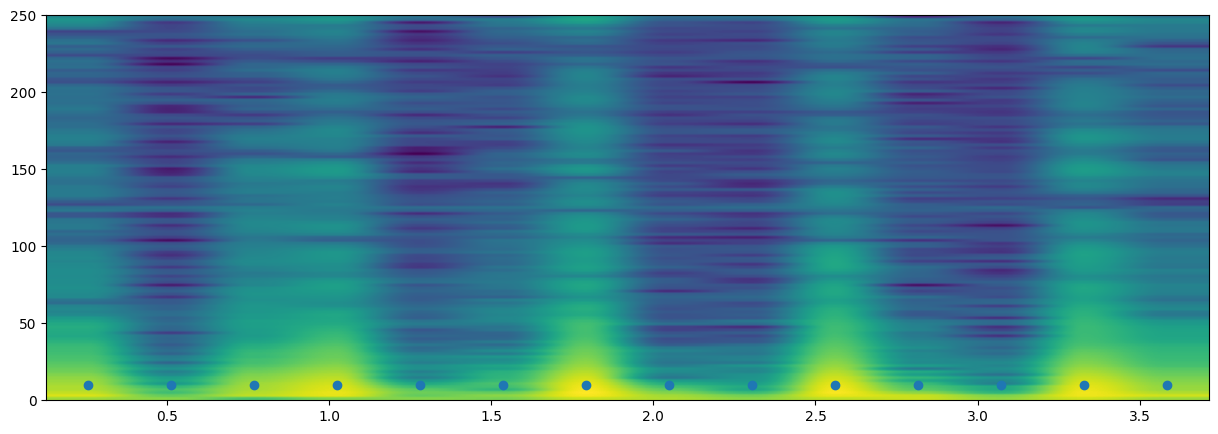

In [ ]:
s = test_loader.dataset[0][0][0]
plt.figure(figsize=(15, 5))
spec = plt.specgram(s, Fs=FREQUENCY)[2]
plt.scatter(spec, np.zeros(spec.shape)+10)

In [ ]:
test_loader.dataset.ecg_seg_plot(0, s)

In [100]:
a = [[1, 2], [3, 4]]

print(a[0][0])

1
